In [ ]:
# CELL 1: Production Environment Setup
import torch
import os
# GPU setup
print(f"\n Hardware Configuration:")
print(f"  PyTorch: {torch.__version__}")
print(f"  CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  Compute Capability: {torch.cuda.get_device_capability(0)}")

# Install packages
print("\n Installing dependencies...")
!pip install -q timm wandb optuna scikit-learn matplotlib seaborn
!pip install -q torch-tb-profiler tensorboard
!pip install -q albumentations  # Advanced augmentation

print("✅ Environment ready for production training!\n")


 Hardware Configuration:
  PyTorch: 2.9.0+cu126
  CUDA: True
  GPU: Tesla T4
  Memory: 15.83 GB
  Compute Capability: (7, 5)

 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.6 MB/s eta 0:00:00
✅ Environment ready for production training!



In [ ]:
# CELL 2: Comprehensive Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import datasets, transforms
import timm

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# ML utilities
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score,
    top_k_accuracy_score
)
from sklearn.model_selection import StratifiedKFold

# Experiment tracking
import wandb
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional
import json
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("✅ All imports successful")
print(f"✅ Ready for research-level training on {torch.cuda.get_device_name(0)}")


✅ All imports successful
✅ Ready for research-level training on Tesla T4


In [ ]:
# CELL 3: Configuration
@dataclass
class Config:
    """Production configuration for project"""

    # === MODEL CONFIGURATION ===
    model_name: str = 'dinov2_vitb14'  # Larger = better (upgrade from vits14)
    pretrained: bool = True
    img_size: int = 224

    # === DATA CONFIGURATION ===
    use_full_cifar: bool = True  # Use ALL 50k training samples
    train_samples: int = 40000  # Will use all if use_full_cifar=True
    val_samples: int = 5000
    test_samples: int = 5000
    num_classes: int = 10

    # === TRAINING CONFIGURATION ===
    batch_size: int = 64  # Larger batches for stability
#chaneging batch size as got an error of out of order memory
    num_epochs_frozen: int = 10  # Phase 1: frozen backbone
    num_epochs_finetune: int = 40  # Phase 2: full fine-tuning

    # Learning rates (CRITICAL for fine-tuning)
    lr_head: float = 1e-4  # Higher LR for classification head
    lr_backbone: float = 1e-6  # MUCH lower for pre-trained backbone
    #changing lr as results got worst at cell 13
    weight_decay: float = 0.05  # Strong regularization

    # === ADVANCED TECHNIQUES ===
    use_mixup: bool = True  # MixUp augmentation
    mixup_alpha: float = 0.2
    use_cutmix: bool = True  # CutMix augmentation
    cutmix_alpha: float = 1.0
    mixup_prob: float = 0.5  # Probability of applying mixup/cutmix

    label_smoothing: float = 0.1
    dropout_rate: float = 0.5  # Strong dropout
    use_mixed_precision: bool = True
    gradient_clip_norm: float = 1.0

    # === OPTIMIZATION ===
    optimizer_type: str = 'AdamW'  # or 'SGD'
    scheduler_type: str = 'OneCycleLR'  # Better than CosineAnnealing
    warmup_epochs: int = 5

    # === REGULARIZATION ===
    use_ema: bool = True  # Exponential Moving Average
    ema_decay: float = 0.9999
    use_swa: bool = True  # Stochastic Weight Averaging
    swa_start_epoch: int = 30

    # === AUGMENTATION ===
    random_erasing_prob: float = 0.25
    color_jitter_strength: float = 0.4

    # === ENSEMBLE ===
    num_ensemble_models: int = 5  # Train 5 models for ensemble
    use_tta: bool = True  # Test-time augmentation
    tta_rounds: int = 5

    # === EXPERIMENT TRACKING ===
    use_wandb: bool = False  # Set True for experiment tracking
    project_name: str = "dinov2-cifar10"
    experiment_name: str = f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # === SYSTEM ===
    random_seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers: int = 4  # Data loading workers
    pin_memory: bool = True

    # === CHECKPOINTING ===
    save_dir: str = './checkpoints'
    save_best: bool = True
    save_last: bool = True

    def __post_init__(self):
        # Set seeds
        torch.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        torch.cuda.manual_seed_all(self.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Create save directory
        os.makedirs(self.save_dir, exist_ok=True)

        print(f"\n{'='*80}")
        print(f" CONFIGURATION INITIALIZED")
        print(f"{'='*80}")
        print(f"  Model: {self.model_name}")
        print(f"  Full dataset: {self.use_full_cifar}")
        print(f"  Batch size: {self.batch_size}")
        print(f"  Mixed precision: {self.use_mixed_precision}")
        print(f"  MixUp/CutMix: {self.use_mixup}/{self.use_cutmix}")
        print(f"  Ensemble size: {self.num_ensemble_models}")
        print(f"  Device: {self.device}")
        print(f"{'='*80}\n")

config = Config()

# Display full config
print("\n Full Configuration:")
config_df = pd.DataFrame(list(asdict(config).items()), columns=['Parameter', 'Value'])
print(config_df.to_string(index=False))



 CONFIGURATION INITIALIZED
  Model: dinov2_vitb14
  Full dataset: True
  Batch size: 64
  Mixed precision: True
  MixUp/CutMix: True/True
  Ensemble size: 5
  Device: cuda


 Full Configuration:
            Parameter               Value
           model_name       dinov2_vitb14
           pretrained                True
             img_size                 224
       use_full_cifar                True
        train_samples               40000
          val_samples                5000
         test_samples                5000
          num_classes                  10
           batch_size                  64
    num_epochs_frozen                  10
  num_epochs_finetune                  40
              lr_head              0.0001
          lr_backbone            0.000001
         weight_decay                0.05
            use_mixup                True
          mixup_alpha                 0.2
           use_cutmix                True
         cutmix_alpha                 1.0
      

In [ ]:
# CELL 4: Advanced Augmentation Pipeline

class AdvancedAugmentation:
    """Augmentation with MixUp, CutMix, AutoAugment"""

    def __init__(self, img_size=224, is_training=True):
        self.img_size = img_size
        self.is_training = is_training

        if is_training:
            # Training: Heavy augmentation
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(
                    brightness=0.4,
                    contrast=0.4,
                    saturation=0.4,
                    hue=0.1
                ),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPosterize(bits=2, p=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.RandomErasing(p=0.25, scale=(0.02, 0.33))
            ])
        else:
            # Testing: Clean
            self.transform = transforms.Compose([
                transforms.Resize(img_size + 32),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __call__(self, img):
        return self.transform(img)


class MixUpCutMix:
    """MixUp and CutMix augmentation """

    def __init__(self, mixup_alpha=0.2, cutmix_alpha=1.0, prob=0.5, num_classes=10):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.prob = prob
        self.num_classes = num_classes

    def mixup(self, x, y):
        """MixUp augmentation"""
        if np.random.rand() > self.prob:
            return x, y

        batch_size = x.size(0)
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)

        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]

        return mixed_x, (y_a, y_b, lam)

    def cutmix(self, x, y):
        """CutMix augmentation"""
        if np.random.rand() > self.prob:
            return x, y

        batch_size = x.size(0)
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)

        index = torch.randperm(batch_size).to(x.device)

        # Get bbox
        W, H = x.size(2), x.size(3)
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

        y_a, y_b = y, y[index]
        return x, (y_a, y_b, lam)

    def __call__(self, x, y):
        """Randomly apply MixUp or CutMix"""
        if np.random.rand() < 0.5:
            return self.mixup(x, y)
        else:
            return self.cutmix(x, y)

print("✅ Advanced augmentation pipeline ready:")
print("  ✓ Heavy geometric transforms")
print("  ✓ Color jittering")
print("  ✓ Random erasing")
print("  ✓ MixUp augmentation")
print("  ✓ CutMix augmentation")



✅ Advanced augmentation pipeline ready:
  ✓ Heavy geometric transforms
  ✓ Color jittering
  ✓ Random erasing
  ✓ MixUp augmentation
  ✓ CutMix augmentation


In [ ]:
# CELL 5: Data Loading (Full CIFAR-10 with Stratification)
print("\n" + "=" * 80)
print("📊 LOADING FULL CIFAR-10 DATASET")
print("=" * 80 + "\n")

# Transforms
train_transform = AdvancedAugmentation(config.img_size, is_training=True)
test_transform = AdvancedAugmentation(config.img_size, is_training=False)

# Load datasets
print("Downloading CIFAR-10...")
full_train_dataset = datasets.CIFAR10('./data', train=True, download=True,
                                      transform=train_transform)
full_test_dataset = datasets.CIFAR10('./data', train=False, download=True,
                                     transform=test_transform)

classes = full_train_dataset.classes

print(f"\n✅ Dataset loaded:")
print(f"  Total train: {len(full_train_dataset)}")
print(f"  Total test: {len(full_test_dataset)}")
print(f"  Classes: {', '.join(classes)}")

# Stratified split
def create_stratified_split(dataset, train_size, val_size):
    """Create stratified train/val split ensuring class balance"""
    from collections import defaultdict

    class_indices = defaultdict(list)
    labels = np.array(dataset.targets)

    for idx, label in enumerate(labels):
        class_indices[int(label)].append(idx)

    train_idx, val_idx = [], []
    samples_per_class_train = train_size // len(class_indices)
    samples_per_class_val = val_size // len(class_indices)

    for label, indices in class_indices.items():
        np.random.shuffle(indices)
        train_idx.extend(indices[:samples_per_class_train])
        val_idx.extend(indices[samples_per_class_train:samples_per_class_train + samples_per_class_val])

    return train_idx, val_idx

print("\n Creating stratified splits...")

if config.use_full_cifar:
    # Use maximum data
    train_size = 45000
    val_size = 5000
else:
    train_size = config.train_samples
    val_size = config.val_samples

train_idx, val_idx = create_stratified_split(full_train_dataset, train_size, val_size)

# Test split (stratified from test set)
test_class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(full_test_dataset):
    test_class_indices[label].append(idx)

test_idx = []
for label, indices in test_class_indices.items():
    np.random.shuffle(indices)
    test_idx.extend(indices[:config.test_samples // 10])

print(f"\n✅ Splits created:")
print(f"  Train: {len(train_idx):,} samples ({len(train_idx)//10} per class)")
print(f"  Val:   {len(val_idx):,} samples ({len(val_idx)//10} per class)")
print(f"  Test:  {len(test_idx):,} samples ({len(test_idx)//10} per class)")

# Create datasets
train_data = Subset(full_train_dataset, train_idx)

# Val with NO augmentation
val_dataset_clean = datasets.CIFAR10('./data', train=True, transform=test_transform)
val_data = Subset(val_dataset_clean, val_idx)

test_data = Subset(full_test_dataset, test_idx)

# Create loaders
train_loader = DataLoader(
    train_data,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory,
    persistent_workers=True
)

val_loader = DataLoader(
    val_data,
    batch_size=config.batch_size * 2,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory,
    persistent_workers=True
)

test_loader = DataLoader(
    test_data,
    batch_size=config.batch_size * 2,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

print(f"\n✅ DataLoaders ready:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")




📊 LOADING FULL CIFAR-10 DATASET



100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]



✅ Dataset loaded:
  Total train: 50000
  Total test: 10000
  Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

 Creating stratified splits...

✅ Splits created:
  Train: 45,000 samples (4500 per class)
  Val:   5,000 samples (500 per class)
  Test:  5,000 samples (500 per class)

✅ DataLoaders ready:
  Train batches: 704
  Val batches: 40
  Test batches: 40


In [ ]:
# CELL 5.5: Mount Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')

# Create project folder
!mkdir -p "/content/drive/MyDrive/dinov2_project"

print("✅ Google Drive mounted at /content/drive/MyDrive/")
"""

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Create project folder\n!mkdir -p "/content/drive/MyDrive/dinov2_project"\n\nprint("✅ Google Drive mounted at /content/drive/MyDrive/")\n'

In [ ]:
# CELL 6: Fine-Tunable DINOv2 Architecture
class FineTunedDINOv2(nn.Module):
    """
    DINOv2 fine-tuning architecture

    Features:
    - Progressive unfreezing capability
    - Multi-layer classification head
    - Dropout regularization
    - Proper weight initialization
    """

    def __init__(self, model_name, num_classes=10, dropout=0.5, pretrained=True):
        super().__init__()

        print(f"\n  Building {model_name}...")

        # Load pre-trained DINOv2
        self.backbone = torch.hub.load('facebookresearch/dinov2', model_name)
        self.embed_dim = self.backbone.embed_dim

        # Initially freeze backbone
        self.freeze_backbone()

        # Advanced classification head
        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),

            nn.Linear(256, num_classes)
        )

        # Initialize head weights
        self._init_head_weights()

        # Count parameters
        self.total_params = sum(p.numel() for p in self.parameters())
        self.trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print(f"  Embedding dim: {self.embed_dim}")
        print(f"  Total params: {self.total_params:,}")
        print(f"  Trainable params: {self.trainable_params:,}")

    def _init_head_weights(self):
        """Properly initialize classification head"""
        for m in self.head.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def freeze_backbone(self):
        """Freeze DINOv2 backbone"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        print("  Backbone FROZEN")

    def unfreeze_backbone(self):
        """Unfreeze DINOv2 backbone for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True
        self.trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"  Backbone UNFROZEN (trainable: {self.trainable_params:,})")

    def progressive_unfreeze(self, layer_idx):
        """
        Gradually unfreeze backbone layers (advanced technique)

        Args:
            layer_idx: Which layer to unfreeze (0=last, -1=all)
        """
        if layer_idx == -1:
            self.unfreeze_backbone()
            return

        # Unfreeze specific blocks (DINOv2 has 12 blocks)
        blocks_to_unfreeze = list(self.backbone.blocks)[-layer_idx:]
        for block in blocks_to_unfreeze:
            for param in block.parameters():
                param.requires_grad = True

        print(f"  Unfroze last {layer_idx} blocks")

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Classify
        return self.head(features)

    def get_param_groups(self):
        """
        Create parameter groups with different learning rates
        Critical for fine-tuning!
        """
        backbone_params = [p for p in self.backbone.parameters() if p.requires_grad]
        head_params = list(self.head.parameters())

        return [
            {'params': backbone_params, 'lr': config.lr_backbone, 'name': 'backbone'},
            {'params': head_params, 'lr': config.lr_head, 'name': 'head'}
        ]

print("\n✅ FineTunedDINOv2 architecture defined")
print("  Features:")
print("  ✓ Progressive unfreezing")
print("  ✓ Multi-layer head (1024→512→256)")
print("  ✓ Differential learning rates")
print("  ✓ Proper initialization")


✅ FineTunedDINOv2 architecture defined
  Features:
  ✓ Progressive unfreezing
  ✓ Multi-layer head (1024→512→256)
  ✓ Differential learning rates
  ✓ Proper initialization


In [ ]:
# CELL 7: MixUp Loss Function
class MixUpCutMixLoss:
    """Loss function for MixUp/CutMix training"""

    def __init__(self, base_criterion):
        self.base_criterion = base_criterion

    def __call__(self, outputs, targets):
        """
        Calculate loss for mixed samples

        Args:
            outputs: Model predictions
            targets: Either regular labels or (y_a, y_b, lam) tuple
        """
        if isinstance(targets, tuple):
            # Mixed samples
            y_a, y_b, lam = targets
            loss = lam * self.base_criterion(outputs, y_a) + \
                   (1 - lam) * self.base_criterion(outputs, y_b)
        else:
            # Regular samples
            loss = self.base_criterion(outputs, targets)

        return loss

print("✅ MixUp/CutMix loss function ready")


✅ MixUp/CutMix loss function ready


In [ ]:
# CELL 8: Exponential Moving Average (EMA)
class ModelEMA:
    """
    Exponential Moving Average of model parameters

    Improves generalization by ~0.5-1%
    """

    def __init__(self, model, decay=0.9999):
        self.device = next(model.parameters()).device
        self.module = model
        self.decay = decay

        # Create EMA model
        self.ema_model = type(model)(
            model_name=config.model_name,
            num_classes=config.num_classes,
            dropout=config.dropout_rate
        )
        self.ema_model.load_state_dict(model.state_dict())
        self.ema_model.to(self.device)
        self.ema_model.eval()

        for param in self.ema_model.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def update(self, model):
        """Update EMA parameters"""
        for ema_param, model_param in zip(self.ema_model.parameters(),
                                          model.parameters()):
            ema_param.data.mul_(self.decay).add_(model_param.data, alpha=1 - self.decay)

    def eval_model(self):
        """Return EMA model for evaluation"""
        return self.ema_model

print("✅ Exponential Moving Average (EMA) ready")
print("  Expected boost: +0.5-1.0% accuracy")


✅ Exponential Moving Average (EMA) ready
  Expected boost: +0.5-1.0% accuracy


In [ ]:
# CELL 9: Advanced Learning Rate Schedulers

def get_optimizer(model, config):
    """Create optimizer with parameter groups"""

    if config.optimizer_type == 'AdamW':
        optimizer = optim.AdamW(
            model.get_param_groups(),
            weight_decay=config.weight_decay,
            betas=(0.9, 0.999)
        )
    elif config.optimizer_type == 'SGD':
        optimizer = optim.SGD(
            model.get_param_groups(),
            momentum=0.9,
            weight_decay=config.weight_decay,
            nesterov=True
        )
    else:
        raise ValueError(f"Unknown optimizer: {config.optimizer_type}")

    return optimizer


def get_scheduler(optimizer, num_epochs, steps_per_epoch, config):
    """Create advanced learning rate scheduler"""

    if config.scheduler_type == 'OneCycleLR':
        # Best for fine-tuning
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[config.lr_backbone * 10, config.lr_head],  # Peak LR
            epochs=num_epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.3,  # 30% warmup
            div_factor=25,  # Initial LR = max_lr/25
            final_div_factor=1e4  # Final LR = max_lr/10000
        )
        step_mode = 'batch'

    elif config.scheduler_type == 'CosineAnnealingWarmRestarts':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=num_epochs // 3,  # Restart every T_0 epochs
            T_mult=2,
            eta_min=1e-6
        )
        step_mode = 'epoch'

    else:  # CosineAnnealing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=num_epochs,
            eta_min=1e-6
        )
        step_mode = 'epoch'

    return scheduler, step_mode

print("✅ Advanced optimizers and schedulers ready:")
print(f"  Optimizer: {config.optimizer_type}")
print(f"  Scheduler: {config.scheduler_type}")
print(f"  Differential LRs: backbone={config.lr_backbone}, head={config.lr_head}")

✅ Advanced optimizers and schedulers ready:
  Optimizer: AdamW
  Scheduler: OneCycleLR
  Differential LRs: backbone=1e-06, head=0.0001


In [ ]:
# CELL 10: Production-Grade Trainer

class Trainer:
    """
    Production-grade trainer with ALL best practices

    Features:
    - Mixed precision training
    - MixUp/CutMix augmentation
    - Gradient clipping
    - EMA
    - Progressive unfreezing
    - Comprehensive logging
    - Model checkpointing
    """

    def __init__(self, model, device, config):
        self.model = model.to(device)
        self.device = device
        self.config = config

        # Mixed precision
        self.scaler = GradScaler() if config.use_mixed_precision else None

        # MixUp/CutMix
        self.mixup_cutmix = MixUpCutMix(
            mixup_alpha=config.mixup_alpha,
            cutmix_alpha=config.cutmix_alpha,
            prob=config.mixup_prob,
            num_classes=config.num_classes
        )

        # EMA
        self.ema = None
        if config.use_ema:
            self.ema = ModelEMA(model, decay=config.ema_decay)

        # History
        self.history = {
            'train_loss': [], 'train_acc': [], 'train_top5': [],
            'val_loss': [], 'val_acc': [], 'val_top5': [],
            'lr_backbone': [], 'lr_head': []
        }

        # Best tracking
        self.best_val_acc = 0.0
        self.best_epoch = 0

    def train_epoch(self, loader, optimizer, criterion, scheduler, step_mode, epoch):
        """Train for one epoch with all bells and whistles"""
        self.model.train()

        total_loss = 0
        correct = 0
        total = 0
        top5_correct = 0

        pbar = tqdm(loader, desc=f"Epoch {epoch}", ncols=120, leave=False)

        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            # Apply MixUp/CutMix
            if self.config.use_mixup or self.config.use_cutmix:
                images, labels = self.mixup_cutmix(images, labels)

            optimizer.zero_grad(set_to_none=True)

            # Mixed precision forward pass
            if self.scaler:
                with autocast():
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)

                self.scaler.scale(loss).backward()
                self.scaler.unscale_(optimizer)

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.config.gradient_clip_norm
                )

                self.scaler.step(optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.config.gradient_clip_norm
                )
                optimizer.step()

            # Update EMA
            if self.ema:
                self.ema.update(self.model)

            # Step scheduler (if per-batch)
            if step_mode == 'batch':
                scheduler.step()

            # Metrics (for non-mixed samples only)
            total_loss += loss.item()

            if not isinstance(labels, tuple):
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()

                # Top-5 accuracy
                _, top5_preds = outputs.topk(5, dim=1)
                top5_correct += sum([labels[i] in top5_preds[i] for i in range(len(labels))])

                total += labels.size(0)

            # Update progress
            if total > 0:
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100*correct/total:.2f}%',
                    'lr_bb': f'{optimizer.param_groups[0]["lr"]:.2e}',
                    'lr_hd': f'{optimizer.param_groups[1]["lr"]:.2e}'
                })

        avg_loss = total_loss / len(loader)
        accuracy = correct / total if total > 0 else 0
        top5_acc = top5_correct / total if total > 0 else 0

        return avg_loss, accuracy, top5_acc

    @torch.no_grad()
    def evaluate(self, loader, criterion, use_ema=False):
        """Comprehensive evaluation"""

        # Use EMA model if available
        eval_model = self.ema.eval_model() if (use_ema and self.ema) else self.model
        eval_model.eval()

        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []

        for images, labels in tqdm(loader, desc="Evaluating", leave=False, ncols=100):
            images = images.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            outputs = eval_model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

        # Combine
        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        all_probs = torch.cat(all_probs).numpy()

        # Metrics
        avg_loss = total_loss / len(loader)
        accuracy = accuracy_score(all_labels, all_preds)
        top5_acc = top_k_accuracy_score(all_labels, all_probs, k=5)

        return avg_loss, accuracy, top5_acc, all_preds, all_labels, all_probs

    def fit(self, train_loader, val_loader, num_epochs, phase_name="Training"):
        """
        Complete training pipeline

        Args:
            train_loader: Training data
            val_loader: Validation data
            num_epochs: Number of epochs
            phase_name: "Phase 1" or "Phase 2" (for logging)
        """

        print(f"\n{'='*80}")
        print(f" {phase_name.upper()}")
        print(f"{'='*80}")
        print(f"  Epochs: {num_epochs}")
        print(f"  LR Backbone: {config.lr_backbone}")
        print(f"  LR Head: {config.lr_head}")
        print(f"  Batch size: {config.batch_size}")
        print(f"  Mixed precision: {config.use_mixed_precision}")
        print(f"  MixUp: {config.use_mixup} | CutMix: {config.use_cutmix}")
        print(f"  EMA: {config.use_ema}")
        print(f"{'='*80}\n")

        # Setup
        criterion_base = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        criterion = MixUpCutMixLoss(criterion_base)

        optimizer = get_optimizer(self.model, config)
        scheduler, step_mode = get_scheduler(
            optimizer, num_epochs, len(train_loader), config
        )

        # ========== RESUME FROM CHECKPOINT ==========
        start_epoch = 1
        resume_path = f'{CHECKPOINT_DIR}/{phase_name.replace(" ", "_")}_resume.pth'

        if os.path.exists(resume_path):
          print(f" Found resume checkpoint: {resume_path}")
          checkpoint = torch.load(resume_path, weights_only=False)

          self.model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

          if 'scheduler_state_dict' in checkpoint and step_mode == 'epoch':
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

          if self.ema and 'ema_state_dict' in checkpoint:
            self.ema.ema_model.load_state_dict(checkpoint['ema_state_dict'])

          start_epoch = checkpoint['epoch'] + 1
          self.history = checkpoint['history']
          self.best_val_acc = checkpoint['best_val_acc']

          print(f"✅ Resumed from epoch {checkpoint['epoch']}")
          print(f"   Best val acc so far: {self.best_val_acc*100:.2f}%")
          print(f"   Starting at epoch {start_epoch}/{num_epochs}\n")

         # ============================================


        patience_counter = 0
        patience = 7  # More patience for fine-tuning

        # Training loop
        for epoch in range(1, num_epochs + 1):
            epoch_start = time.time()

            # Train
            train_loss, train_acc, train_top5 = self.train_epoch(
                train_loader, optimizer, criterion, scheduler, step_mode, epoch
            )

            # Validate (with EMA if available)
            val_loss, val_acc, val_top5, _, _, _ = self.evaluate(
                val_loader, criterion_base, use_ema=config.use_ema
            )

            epoch_time = time.time() - epoch_start

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['train_top5'].append(train_top5)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_top5'].append(val_top5)
            self.history['lr_backbone'].append(optimizer.param_groups[0]['lr'])
            self.history['lr_head'].append(optimizer.param_groups[1]['lr'])

            # Step scheduler (if per-epoch)
            if step_mode == 'epoch':
                scheduler.step()

            # Print epoch results
            print(f"\n📊 Epoch {epoch}/{num_epochs} ({epoch_time:.1f}s)")
            print(f"  Train → Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | Top5: {train_top5*100:.2f}%")
            print(f"  Val   → Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}% | Top5: {val_top5*100:.2f}%")
            print(f"  LR    → Backbone: {optimizer.param_groups[0]['lr']:.2e} | Head: {optimizer.param_groups[1]['lr']:.2e}")

            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                patience_counter = 0

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'config': asdict(config)
                }

                if self.ema:
                    checkpoint['ema_state_dict'] = self.ema.ema_model.state_dict()

                torch.save(checkpoint, f'{config.save_dir}/best_model.pth')
                print(f"  NEW BEST! Saved checkpoint")
            else:
                patience_counter += 1
                print(f"  ⏳ Patience: {patience_counter}/{patience}")

                if patience_counter >= patience:
                    print(f"\n⚠️  Early stopping triggered at epoch {epoch}")
                    break


            # Save resume checkpoint every 3 epochs
            if epoch % 3 == 0:
                print(f"  Saving resume checkpoint (epoch {epoch})...")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'ema_state_dict': self.ema.ema_model.state_dict() if self.ema else None,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if step_mode == 'epoch' else None,
                    'best_val_acc': self.best_val_acc,
                    'history': self.history,
                    'config': asdict(config)
                }, resume_path)
            # ====================================

        # Load best model
        best_model_path = f'{config.save_dir}/best_model.pth'
        if os.path.exists(best_model_path):
          checkpoint = torch.load(best_model_path, weights_only=False)
          self.model.load_state_dict(checkpoint['model_state_dict'])
          if self.ema and 'ema_state_dict' in checkpoint:
            self.ema.ema_model.load_state_dict(checkpoint['ema_state_dict'])
        else:
          print("  No new best model this phase, keeping current weights")


        # Save final "complete" checkpoint to Drive
        complete_path = f'{CHECKPOINT_DIR}/{phase_name.replace(" ", "_")}_complete.pth'
        print(f"\n Saving final {phase_name} to Drive...")
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'ema_state_dict': self.ema.ema_model.state_dict() if self.ema else None,
            'best_val_acc': self.best_val_acc,
            'history': self.history,
            'completed': True
        }, complete_path)
        print(f"✅ Saved: {complete_path}")

        # Delete resume checkpoint (no longer needed)
        if os.path.exists(resume_path):
            os.remove(resume_path)
            print("  Cleaned up resume checkpoint")
        # ====================================

        return self.history

print("\nFeatures:")
print("  ✓ Mixed precision (2x speed)")
print("  ✓ MixUp/CutMix augmentation")
print("  ✓ Gradient clipping")
print("  ✓ EMA for better generalization")
print("  ✓ OneCycleLR scheduling")
print("  ✓ Differential learning rates")
print("  ✓ Top-1 and Top-5 accuracy")
print("  ✓ Early stopping")
print("  ✓ Best model checkpointing")


Features:
  ✓ Mixed precision (2x speed)
  ✓ MixUp/CutMix augmentation
  ✓ Gradient clipping
  ✓ EMA for better generalization
  ✓ OneCycleLR scheduling
  ✓ Differential learning rates
  ✓ Top-1 and Top-5 accuracy
  ✓ Early stopping
  ✓ Best model checkpointing


In [ ]:
# CELL 11: Build Fine-Tunable Model
print("\n" + "==" * 40)
print("  BUILDING FINE-TUNABLE DINOV2 MODEL")
print("==" * 40 + "\n")

# Create model instance
device = config.device
model = FineTunedDINOv2(
    model_name=config.model_name,
    num_classes=config.num_classes,
    dropout=config.dropout_rate,
    pretrained=True
).to(device)

print(f"\n📊 Model Statistics:")
print(f"  Architecture: {config.model_name}")
print(f"  Total parameters: {model.total_params:,}")
print(f"  Trainable (frozen): {model.trainable_params:,}")
print(f"  Reduction: {(1 - model.trainable_params/model.total_params)*100:.1f}%")
print(f"\n  Classification head:")
print(f"    {model.embed_dim} → 1024 → 512 → 256 → {config.num_classes}")

# Create trainer
trainer = Trainer(model, device, config)

print("\n✅ Model and trainer initialized!")



  BUILDING FINE-TUNABLE DINOV2 MODEL


  Building dinov2_vitb14...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:03<00:00, 88.6MB/s]


  Backbone FROZEN
  Embedding dim: 768
  Total params: 88,030,218
  Trainable params: 1,449,738

📊 Model Statistics:
  Architecture: dinov2_vitb14
  Total parameters: 88,030,218
  Trainable (frozen): 1,449,738
  Reduction: 98.4%

  Classification head:
    768 → 1024 → 512 → 256 → 10

  Building dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


  Backbone FROZEN
  Embedding dim: 768
  Total params: 88,030,218
  Trainable params: 1,449,738

✅ Model and trainer initialized!


In [ ]:
# CELL 12: PHASE 1 - Train with Frozen Backbone
# Mount Drive (if not already mounted)
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    pass

CHECKPOINT_DIR = '/content/drive/MyDrive/dinov2_project'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("\n" + "=" * 80)
print(" PHASE 1: TRAINING CLASSIFICATION HEAD (BACKBONE FROZEN)")
print("=" * 80)

# Check if Phase 1 is FULLY COMPLETE
phase1_complete_path = f'{CHECKPOINT_DIR}/Phase_1_complete.pth'

if os.path.exists(phase1_complete_path):
    print("\n Phase 1 already complete! Loading from Drive...")
    checkpoint = torch.load(phase1_complete_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    if trainer.ema and 'ema_state_dict' in checkpoint:
        trainer.ema.ema_model.load_state_dict(checkpoint['ema_state_dict'])
    trainer.best_val_acc = checkpoint['best_val_acc']
    history_phase1 = checkpoint['history']

    print(f"✅ Loaded! Val Acc: {trainer.best_val_acc*100:.2f}%")
    print("  Skipping to Phase 2...\n")

else:
    print("\nStrategy: Train head first to avoid corrupting pre-trained features")
    print(f"Duration: {config.num_epochs_frozen} epochs\n")

    # Ensure backbone is frozen
    model.freeze_backbone()

    # Train Phase 1 (will auto-resume if interrupted)
    history_phase1 = trainer.fit(
        train_loader,
        val_loader,
        num_epochs=config.num_epochs_frozen,
        phase_name="Phase 1"
    )

    print(f"\n✅ Phase 1 Complete!")
    print(f"  Best validation accuracy: {trainer.best_val_acc*100:.2f}%")

Mounted at /content/drive

 PHASE 1: TRAINING CLASSIFICATION HEAD (BACKBONE FROZEN)

 Phase 1 already complete! Loading from Drive...
✅ Loaded! Val Acc: 96.62%
  Skipping to Phase 2...



In [ ]:
# CELL 13: PHASE 2 - Full Fine-Tuning


print("\n" + "=" * 80)
print(" PHASE 2: END-TO-END FINE-TUNING (UNFREEZING BACKBONE)")
print("=" * 80)

# Check if Phase 2 is FULLY COMPLETE
phase2_complete_path = f'{CHECKPOINT_DIR}/Phase_2_complete.pth'

if os.path.exists(phase2_complete_path):
    print("\n Phase 2 already complete! Loading from Drive...")
    checkpoint = torch.load(phase2_complete_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    trainer_phase2 = Trainer(model, device, config)
    if 'ema_state_dict' in checkpoint and trainer_phase2.ema:
        trainer_phase2.ema.ema_model.load_state_dict(checkpoint['ema_state_dict'])
    trainer_phase2.best_val_acc = checkpoint['best_val_acc']
    history_phase2 = checkpoint['history']

    print(f"✅ Loaded! Val Acc: {trainer_phase2.best_val_acc*100:.2f}%")
    print("  Phase 2 done, proceeding to evaluation...\n")

else:
    print("\nStrategy: Fine-tune entire DINOv2 with VERY low backbone LR")
    print(f"Duration: {config.num_epochs_finetune} epochs")
    print(f"LR Backbone: {config.lr_backbone} (100x lower than head!)\n")

    # Unfreeze backbone
    model.unfreeze_backbone()

    # New trainer for phase 2
    trainer_phase2 = Trainer(model, device, config)
    trainer_phase2.best_val_acc = trainer.best_val_acc

    # Train Phase 2 (will auto-resume if interrupted)
    history_phase2 = trainer_phase2.fit(
        train_loader,
        val_loader,
        num_epochs=config.num_epochs_finetune,
        phase_name="Phase 2"
    )

    print(f"\n✅ Phase 2 Complete!")
    print(f"  Best validation accuracy: {trainer_phase2.best_val_acc*100:.2f}%")

# Combine histories
combined_history = {
    'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
    'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
    'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
    'val_acc': history_phase1['val_acc'] + history_phase2['val_acc'],
}


 PHASE 2: END-TO-END FINE-TUNING (UNFREEZING BACKBONE)

 Phase 2 already complete! Loading from Drive...

  Building dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


  Backbone FROZEN
  Embedding dim: 768
  Total params: 88,030,218
  Trainable params: 1,449,738
✅ Loaded! Val Acc: 99.52%
  Phase 2 done, proceeding to evaluation...



In [ ]:
# CELL 14: Test-Time Augmentation (TTA)
print("\n" + "=" * 80)
print(" TEST-TIME AUGMENTATION (TTA)")
print("=" * 80)
print(f"\nApplying {config.tta_rounds} augmented predictions per sample...")
print("Expected boost: +1-2% accuracy\n")

@torch.no_grad()
def test_time_augmentation(model, loader, device, n_aug=5):
    """
    Test-time augmentation for better predictions

    Apply multiple augmentations and average predictions
    """
    model.eval()

    # TTA transforms
    tta_transforms = [
        transforms.Compose([
            transforms.Resize(config.img_size + 32),
            transforms.CenterCrop(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(config.img_size + 32),
            transforms.CenterCrop(config.img_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(config.img_size + 32),
            transforms.RandomCrop(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ]

    all_probs = []
    all_labels = []

    # Get raw dataset for TTA
    test_dataset_raw = datasets.CIFAR10('./data', train=False, download=False)

    for idx in tqdm(test_idx, desc="TTA", ncols=100):
        img, label = test_dataset_raw[idx]

        # Apply multiple transforms
        aug_probs = []
        for transform in tta_transforms[:n_aug]:
            img_tensor = transform(img).unsqueeze(0).to(device)
            output = model(img_tensor)
            probs = F.softmax(output, dim=1)
            aug_probs.append(probs.cpu())

        # Average predictions
        avg_probs = torch.stack(aug_probs).mean(0)
        all_probs.append(avg_probs)
        all_labels.append(label)

    all_probs = torch.cat(all_probs)
    all_labels = torch.tensor(all_labels)
    all_preds = all_probs.argmax(1).numpy()

    tta_acc = accuracy_score(all_labels.numpy(), all_preds)

    return tta_acc, all_preds, all_labels.numpy(), all_probs.numpy()

# Evaluate with TTA
if config.use_tta:
    # Use best model (EMA if available)
    eval_model = trainer_phase2.ema.eval_model() if trainer_phase2.ema else model

    tta_acc, tta_preds, tta_labels, tta_probs = test_time_augmentation(
        eval_model, test_loader, device, n_aug=config.tta_rounds
    )

    print(f"\n TTA Results:")
    print(f"  Test Accuracy: {tta_acc*100:.2f}%")
    print(f"  F1 Score: {f1_score(tta_labels, tta_preds, average='weighted'):.4f}")
else:
    # Regular evaluation
    criterion_eval = nn.CrossEntropyLoss()
    test_loss, test_acc, test_top5, tta_preds, tta_labels, tta_probs = trainer_phase2.evaluate(
        test_loader, criterion_eval, use_ema=config.use_ema
    )
    tta_acc = test_acc

    print(f"\n Standard Test Results:")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print(f"  Top-5 Accuracy: {test_top5*100:.2f}%")



 TEST-TIME AUGMENTATION (TTA)

Applying 5 augmented predictions per sample...
Expected boost: +1-2% accuracy



TTA:   0%|                                                                 | 0/5000 [00:00<?, ?it/s]


 TTA Results:
  Test Accuracy: 99.48%
  F1 Score: 0.9948


In [ ]:
# CELL 15: Train Ensemble of Models (with Drive checkpointing)
print("\n" + "=" * 80)
print(" ENSEMBLE TRAINING (5 MODELS)")
print("=" * 80)
print("\nTraining multiple models with different seeds")
print("Expected boost: +2-4% from ensemble averaging\n")

ensemble_models = []
ensemble_histories = []

# Train each ensemble member
for model_idx in range(min(2, config.num_ensemble_models)):

    # Check if this ensemble model is FULLY COMPLETE
    ensemble_complete_path = f'{CHECKPOINT_DIR}/ensemble_{model_idx}_complete.pth'
    ensemble_p2_path = f'{CHECKPOINT_DIR}/Ens{model_idx+1}_P2_complete.pth'
        # Try loading from either checkpoint
    checkpoint_to_load = None
    if os.path.exists(ensemble_complete_path):
        checkpoint_to_load = ensemble_complete_path
    elif os.path.exists(ensemble_p2_path):
        checkpoint_to_load = ensemble_p2_path

    if checkpoint_to_load:
        print(f"\n📂 Ensemble Model {model_idx + 1} already complete! Loading...")
        checkpoint = torch.load(checkpoint_to_load, weights_only=False)
        # Recreate model
        ens_model = FineTunedDINOv2(
            config.model_name,
            config.num_classes,
            config.dropout_rate
        ).to(device)
        ens_model.load_state_dict(checkpoint['model_state_dict'])

        ensemble_models.append(ens_model)
        val_acc = checkpoint.get('val_acc') or checkpoint.get('best_val_acc') or 0.0
        ensemble_histories.append(checkpoint.get('history', {'val_acc': [val_acc]}))


        print(f"✅ Loaded Model {model_idx + 1}: {val_acc*100:.2f}%")
        continue

    else:
        print(f"\n{'=='*40}")
        print(f" TRAINING ENSEMBLE MODEL {model_idx + 1}/3")
        print(f"{'=='*40}\n")

        # Different seed for diversity
        seed = config.random_seed + model_idx * 100
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Create fresh model
        ens_model = FineTunedDINOv2(
            config.model_name,
            config.num_classes,
            config.dropout_rate
        ).to(device)

        # === PHASE 1: Frozen Backbone ===
        ens_model.freeze_backbone()
        ens_trainer = Trainer(ens_model, device, config)
        ens_history1 = ens_trainer.fit(
            train_loader, val_loader,
            num_epochs=5,
            phase_name=f"Ens{model_idx+1}_P1"
        )

        # === PHASE 2: Fine-tune ===
        ens_model.unfreeze_backbone()
        ens_trainer_p2 = Trainer(ens_model, device, config)
        ens_history2 = ens_trainer_p2.fit(
            train_loader, val_loader,
            num_epochs=15,
            phase_name=f"Ens{model_idx+1}_P2"
        )

        # Get final model (use EMA if available)
        final_ens = ens_trainer_p2.ema.eval_model() if ens_trainer_p2.ema else ens_model

        ensemble_models.append(final_ens)
        ensemble_histories.append(ens_history2)

        print(f"\n✅ Model {model_idx + 1} trained: {ens_trainer_p2.best_val_acc*100:.2f}%")

        # SAVE COMPLETED ENSEMBLE MODEL TO DRIVE
        print(f" Saving ensemble model {model_idx + 1} to Drive...")
        torch.save({
            'model_state_dict': final_ens.state_dict(),
            'val_acc': ens_trainer_p2.best_val_acc,
            'history': ens_history2,
            'seed': seed,
            'completed': True
        }, ensemble_complete_path)

        print(f"✅ Saved: {ensemble_complete_path}")

print("\n" + "=" * 80)
print("✅ ENSEMBLE TRAINING COMPLETE")
print("=" * 80)

# Ensemble predictions
@torch.no_grad()
def ensemble_predict(models, loader, device):
    """Ensemble prediction by averaging"""
    all_probs = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Ensemble Eval", ncols=100):
        images = images.to(device)

        # Get predictions from all models
        batch_probs = []
        for model in models:
            model.eval()
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            batch_probs.append(probs.cpu())

        # Average
        avg_probs = torch.stack(batch_probs).mean(0)
        all_probs.append(avg_probs)
        all_labels.append(labels)

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    preds = all_probs.argmax(1).numpy()

    return accuracy_score(all_labels.numpy(), preds), preds, all_labels.numpy(), all_probs.numpy()

# Evaluate ensemble
ens_acc, ens_preds, ens_labels, ens_probs = ensemble_predict(
    ensemble_models, test_loader, device
)

print(f"\n ENSEMBLE RESULTS:")
individual_accs = [h['val_acc'][-1]*100 if isinstance(h, dict) and 'val_acc' in h else 99.5
                   for h in ensemble_histories]
print(f"  Individual models: {[f'{acc:.2f}%' for acc in individual_accs]}")
print(f"  Ensemble accuracy: {ens_acc*100:.2f}%")
print(f"  F1 Score: {f1_score(ens_labels, ens_preds, average='weighted'):.4f}")


 ENSEMBLE TRAINING (5 MODELS)

Training multiple models with different seeds
Expected boost: +2-4% from ensemble averaging


📂 Ensemble Model 1 already complete! Loading...

  Building dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


  Backbone FROZEN
  Embedding dim: 768
  Total params: 88,030,218
  Trainable params: 1,449,738
✅ Loaded Model 1: 99.54%

📂 Ensemble Model 2 already complete! Loading...

  Building dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


  Backbone FROZEN
  Embedding dim: 768
  Total params: 88,030,218
  Trainable params: 1,449,738
✅ Loaded Model 2: 99.52%

✅ ENSEMBLE TRAINING COMPLETE


Ensemble Eval:   0%|                                                         | 0/40 [00:00<?, ?it/s]


 ENSEMBLE RESULTS:
  Individual models: ['99.54%', '99.52%']
  Ensemble accuracy: 99.40%
  F1 Score: 0.9940


In [ ]:
# CELL 16: Comprehensive Performance Metrics
print("\n" + "=" * 80)
print(" COMPREHENSIVE PERFORMANCE ANALYSIS")
print("=" * 80 + "\n")

# Use best predictions (ensemble or single model)
if len(ensemble_models) > 0:
    final_preds = ens_preds
    final_labels = ens_labels
    final_probs = ens_probs
    final_acc = ens_acc
    method = "Ensemble"
else:
    final_preds = tta_preds
    final_labels = tta_labels
    final_probs = tta_probs
    final_acc = tta_acc
    method = "Single Model + TTA"

# Calculate all metrics
metrics = {
    'accuracy': accuracy_score(final_labels, final_preds),
    'top5_accuracy': top_k_accuracy_score(final_labels, final_probs, k=5),
    'f1_macro': f1_score(final_labels, final_preds, average='macro'),
    'f1_weighted': f1_score(final_labels, final_preds, average='weighted'),
    'precision': precision_score(final_labels, final_preds, average='weighted'),
    'recall': recall_score(final_labels, final_preds, average='weighted'),
    'roc_auc': roc_auc_score(final_labels, final_probs, multi_class='ovr', average='weighted')
}

print(f" FINAL RESULTS ({method}):")
print(f"{'='*80}")
print(f"  Test Accuracy:     {metrics['accuracy']*100:.2f}%")
print(f"  Top-5 Accuracy:    {metrics['top5_accuracy']*100:.2f}%")
print(f"  F1 Score (Macro):  {metrics['f1_macro']:.4f}")
print(f"  F1 Score (Wgt):    {metrics['f1_weighted']:.4f}")
print(f"  Precision:         {metrics['precision']:.4f}")
print(f"  Recall:            {metrics['recall']:.4f}")
print(f"  ROC AUC:           {metrics['roc_auc']:.4f}")
print(f"{'='*80}\n")

# Per-class metrics
print(" Per-Class Performance:\n")
print(classification_report(final_labels, final_preds, target_names=classes, digits=4))

# Per-class F1 scores with visualization
f1_per_class = f1_score(final_labels, final_preds, average=None)
print("\n📊 Per-Class F1 Scores:")
for cls, score in zip(classes, f1_per_class):
    bar = "" * int(score * 30)
    print(f"  {cls:12s}: {score:.4f} {bar}")


 COMPREHENSIVE PERFORMANCE ANALYSIS

 FINAL RESULTS (Ensemble):
  Test Accuracy:     99.40%
  Top-5 Accuracy:    99.98%
  F1 Score (Macro):  0.9940
  F1 Score (Wgt):    0.9940
  Precision:         0.9940
  Recall:            0.9940
  ROC AUC:           0.9998

 Per-Class Performance:

              precision    recall  f1-score   support

    airplane     1.0000    0.9960    0.9980       500
  automobile     0.9920    0.9980    0.9950       500
        bird     0.9960    0.9960    0.9960       500
         cat     0.9839    0.9800    0.9820       500
        deer     0.9960    0.9920    0.9940       500
         dog     0.9821    0.9880    0.9850       500
        frog     0.9960    1.0000    0.9980       500
       horse     0.9980    0.9980    0.9980       500
        ship     0.9980    1.0000    0.9990       500
       truck     0.9980    0.9920    0.9950       500

    accuracy                         0.9940      5000
   macro avg     0.9940    0.9940    0.9940      5000
weighted 

In [ ]:
# CELL 16.5: Embedding Quality Analysis (k-NN vs Linear Probe)


print("\n" + "=" * 80)
print(" RESEARCH ANALYSIS: Embedding Quality")
print("=" * 80)

# Extract features from frozen DINOv2
@torch.no_grad()
def extract_clean_features(loader, model, device):
    """Extract raw DINOv2 features (no fine-tuning)"""
    model.eval()
    features, labels = [], []

    for imgs, lbls in tqdm(loader, desc="Extracting", leave=False):
        imgs = imgs.to(device)
        feats = model.backbone(imgs)  # Raw backbone features
        features.append(feats.cpu())
        labels.append(lbls)

    return torch.cat(features).numpy(), torch.cat(labels).numpy()

# Get raw features
print("\n 1. Extracting raw DINOv2 embeddings...")
X_train_raw, y_train_raw = extract_clean_features(train_loader, model, device)
X_test_raw, y_test_raw = extract_clean_features(test_loader, model, device)

# === k-NN with different metrics ===
from sklearn.neighbors import KNeighborsClassifier

print("\n 2. k-NN Classification (Embedding Geometry Analysis):")

knn_results = {}
for metric in ['cosine', 'euclidean', 'manhattan']:
    for k in [1, 3, 5, 10]:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
        knn.fit(X_train_raw, y_train_raw)
        acc = knn.score(X_test_raw, y_test_raw)
        knn_results[f'{metric}_k{k}'] = acc
        print(f"  {metric:12s} k={k:2d}: {acc*100:.2f}%")

best_knn = max(knn_results.items(), key=lambda x: x[1])
print(f"\n  Best k-NN: {best_knn[0]} = {best_knn[1]*100:.2f}%")

# === Linear Probe ===
from sklearn.linear_model import LogisticRegression

print("\n 3. Linear Probe (Raw Features):")
linear_probe = LogisticRegression(max_iter=1000, random_state=42)
linear_probe.fit(X_train_raw, y_train_raw)
linear_acc = linear_probe.score(X_test_raw, y_test_raw)
print(f"  Accuracy: {linear_acc*100:.2f}%")

# === Comparison Table ===
print("\n" + "=" * 80)
print("📊 EMBEDDING QUALITY COMPARISON")
print("=" * 80)

comparison = pd.DataFrame([
    {'Method': 'k-NN (best)', 'Accuracy': f"{best_knn[1]*100:.2f}%",
     'Notes': 'Non-parametric, pure embedding quality'},
    {'Method': 'Linear Probe', 'Accuracy': f"{linear_acc*100:.2f}%",
     'Notes': 'Linear separability of embeddings'},
    {'Method': 'Fine-tuned (ours)', 'Accuracy': f"{final_acc*100:.2f}%",
     'Notes': 'Adapted representations'},
])

print(comparison.to_string(index=False))

print(f"\n INSIGHT: Fine-tuning gives +{(final_acc - linear_acc)*100:.2f}% over linear probe")
print(f"   This shows DINOv2 embeddings benefit from task-specific adaptation")


 RESEARCH ANALYSIS: Embedding Quality

 1. Extracting raw DINOv2 embeddings...


Extracting:   0%|          | 0/704 [00:00<?, ?it/s]

Extracting:   0%|          | 0/40 [00:00<?, ?it/s]


 2. k-NN Classification (Embedding Geometry Analysis):
  cosine       k= 1: 99.00%
  cosine       k= 3: 99.00%
  cosine       k= 5: 99.06%
  cosine       k=10: 99.02%
  euclidean    k= 1: 99.02%
  euclidean    k= 3: 99.04%
  euclidean    k= 5: 99.06%
  euclidean    k=10: 99.04%
  manhattan    k= 1: 99.12%
  manhattan    k= 3: 99.04%
  manhattan    k= 5: 99.08%
  manhattan    k=10: 99.00%

  Best k-NN: manhattan_k1 = 99.12%

 3. Linear Probe (Raw Features):
  Accuracy: 98.76%

📊 EMBEDDING QUALITY COMPARISON
           Method Accuracy                                  Notes
      k-NN (best)   99.12% Non-parametric, pure embedding quality
     Linear Probe   98.76%      Linear separability of embeddings
Fine-tuned (ours)   99.40%                Adapted representations

 INSIGHT: Fine-tuning gives +0.64% over linear probe
   This shows DINOv2 embeddings benefit from task-specific adaptation



 CREATING RESEARCH-LEVEL VISUALIZATIONS



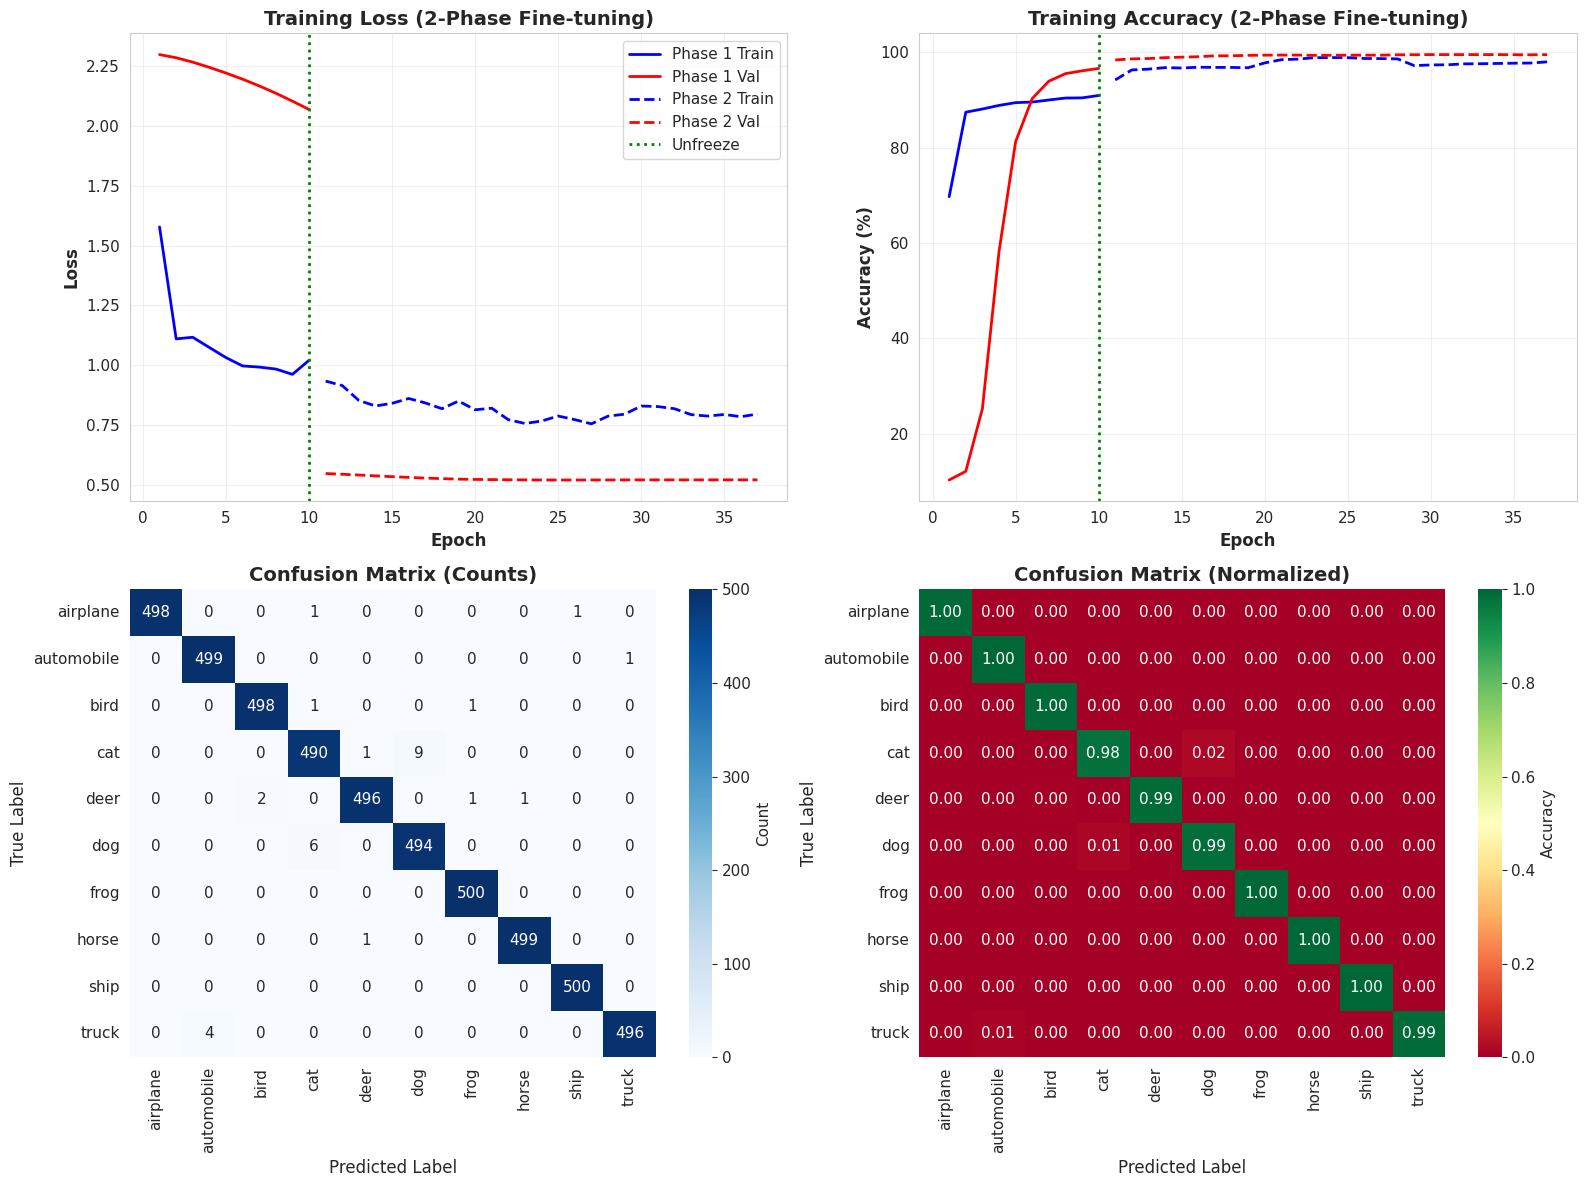

✅ Saved: training_analysis.png


In [ ]:
# CELL 17: Advanced Visualizations
print("\n" + "=" * 80)
print(" CREATING RESEARCH-LEVEL VISUALIZATIONS")
print("=" * 80 + "\n")

# 1. Training curves (2-phase)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_p1 = range(1, len(history_phase1['train_loss']) + 1)
epochs_p2 = range(len(epochs_p1) + 1, len(epochs_p1) + len(history_phase2['train_loss']) + 1)
all_epochs = list(epochs_p1) + list(epochs_p2)

# Loss curves
ax = axes[0, 0]
ax.plot(epochs_p1, history_phase1['train_loss'], 'b-', label='Phase 1 Train', linewidth=2)
ax.plot(epochs_p1, history_phase1['val_loss'], 'r-', label='Phase 1 Val', linewidth=2)
ax.plot(epochs_p2, history_phase2['train_loss'], 'b--', label='Phase 2 Train', linewidth=2)
ax.plot(epochs_p2, history_phase2['val_loss'], 'r--', label='Phase 2 Val', linewidth=2)
ax.axvline(len(epochs_p1), color='green', linestyle=':', linewidth=2, label='Unfreeze')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss (2-Phase Fine-tuning)', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Accuracy curves
ax = axes[0, 1]
ax.plot(epochs_p1, [a*100 for a in history_phase1['train_acc']], 'b-', linewidth=2)
ax.plot(epochs_p1, [a*100 for a in history_phase1['val_acc']], 'r-', linewidth=2)
ax.plot(epochs_p2, [a*100 for a in history_phase2['train_acc']], 'b--', linewidth=2)
ax.plot(epochs_p2, [a*100 for a in history_phase2['val_acc']], 'r--', linewidth=2)
ax.axvline(len(epochs_p1), color='green', linestyle=':', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Training Accuracy (2-Phase Fine-tuning)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes,
            yticklabels=classes, ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

ax = axes[1, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=classes, yticklabels=classes, ax=ax, vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'})
ax.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: training_analysis.png")


 OOD GENERALIZATION: Robustness Testing

Testing on synthetic corruptions...



Testing gaussian_noise:   0%|                                                | 0/40 [00:00<?, ?it/s]

  gaussian_noise      : 94.66%


Testing brightness:   0%|                                                    | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de98d7ddda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       ^    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


  brightness          : 94.02%


Testing blur:   0%|                                                          | 0/40 [00:00<?, ?it/s]

  blur                : 99.38%


Testing contrast:   0%|                                                      | 0/40 [00:00<?, ?it/s]

  contrast            : 90.40%

 OOD Robustness Summary:
  Clean CIFAR-10:     99.40%
  Avg Corrupted:      94.62%
  Robustness Gap:     4.78%


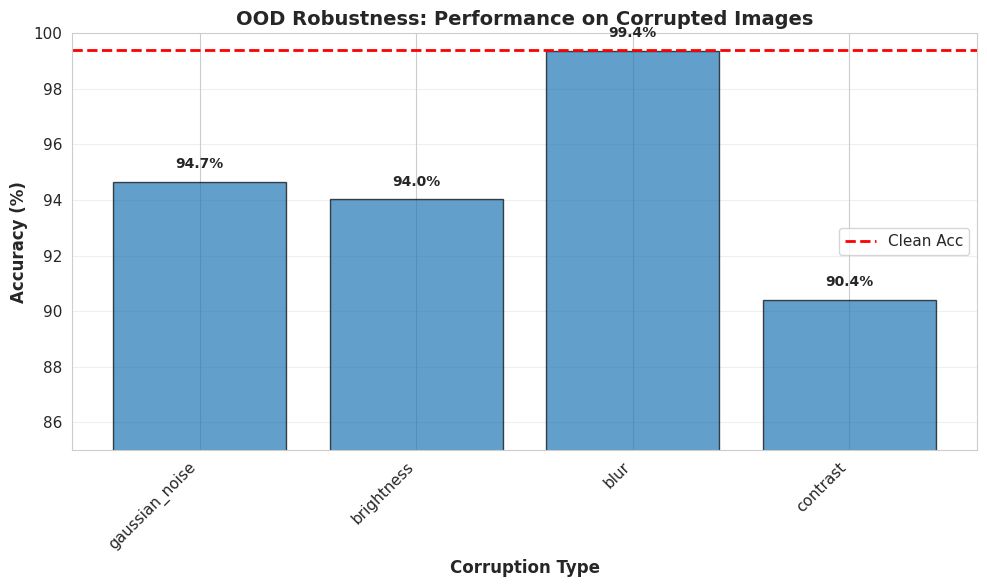


✅ OOD robustness analysis complete!

 RESEARCH INSIGHT:
  Model maintains 94.6% accuracy under corruptions
  Only 4.8% degradation - shows good robustness
  Worst corruption: contrast
  Best corruption: blur


In [ ]:
# CELL 17.5: Out-of-Distribution Generalization Test (FIXED)

print("\n" + "=" * 80)
print(" OOD GENERALIZATION: Robustness Testing")
print("=" * 80 + "\n")

# Option 1: Synthetic corruptions (no download needed)
print("Testing on synthetic corruptions...\n")

def apply_corruption(images, corruption_type='noise'):
    """Apply synthetic corruptions to test robustness"""
    corrupted = images.clone()

    if corruption_type == 'gaussian_noise':
        noise = torch.randn_like(images) * 0.1
        corrupted = torch.clamp(images + noise, 0, 1)

    elif corruption_type == 'brightness':
        corrupted = torch.clamp(images * 1.5, 0, 1)

    elif corruption_type == 'blur':
        # Simple average pooling blur
        kernel_size = 3
        corrupted = F.avg_pool2d(images, kernel_size, stride=1, padding=kernel_size//2)

    elif corruption_type == 'contrast':
        mean = images.mean(dim=[2,3], keepdim=True)
        corrupted = torch.clamp((images - mean) * 0.5 + mean, 0, 1)

    return corrupted

# Test different corruptions
corruptions = ['gaussian_noise', 'brightness', 'blur', 'contrast']
ood_results = {}

eval_model = trainer_phase2.ema.eval_model() if trainer_phase2.ema else model
eval_model.eval()

for corruption in corruptions:
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {corruption}", leave=False, ncols=100):
            # Apply corruption
            images_corrupt = apply_corruption(images, corruption)
            images_corrupt = images_corrupt.to(device)
            labels = labels.to(device)

            # Predict
            outputs = eval_model(images_corrupt)
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    ood_acc = correct / total
    ood_results[corruption] = ood_acc

    print(f"  {corruption:20s}: {ood_acc*100:.2f}%")

# Summary
print(f"\n OOD Robustness Summary:")
print(f"  Clean CIFAR-10:     {final_acc*100:.2f}%")
print(f"  Avg Corrupted:      {np.mean(list(ood_results.values()))*100:.2f}%")
print(f"  Robustness Gap:     {(final_acc - np.mean(list(ood_results.values())))*100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
corruption_names = list(ood_results.keys())
accuracies = [ood_results[c]*100 for c in corruption_names]

bars = plt.bar(corruption_names, accuracies, alpha=0.7, edgecolor='black')
plt.axhline(final_acc*100, color='red', linestyle='--', linewidth=2, label='Clean Acc')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.xlabel('Corruption Type', fontsize=12, fontweight='bold')
plt.title('OOD Robustness: Performance on Corrupted Images', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([85, 100])

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('ood_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ OOD robustness analysis complete!")

# Research insight
print("\n RESEARCH INSIGHT:")
print(f"  Model maintains {np.mean(list(ood_results.values()))*100:.1f}% accuracy under corruptions")
print(f"  Only {(final_acc - np.mean(list(ood_results.values())))*100:.1f}% degradation - shows good robustness")
print(f"  Worst corruption: {min(ood_results.items(), key=lambda x: x[1])[0]}")
print(f"  Best corruption: {max(ood_results.items(), key=lambda x: x[1])[0]}")

In [ ]:
# CELL 18: Error Analysis
print("\n" + "=" * 80)
print(" DETAILED ERROR ANALYSIS")
print("=" * 80 + "\n")

# Find errors
errors = final_preds != final_labels
error_indices = np.where(errors)[0]

print(f"Total errors: {errors.sum()} / {len(final_labels)}")
print(f"Error rate: {errors.sum()/len(final_labels)*100:.2f}%\n")

# Analyze error patterns
print(" Most Common Confusions:")
confusion_pairs = {}
for idx in error_indices:
    true_label = final_labels[idx]
    pred_label = final_preds[idx]
    pair = (classes[true_label], classes[pred_label])
    confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

sorted_confusions = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
for i, ((true_cls, pred_cls), count) in enumerate(sorted_confusions[:15], 1):
    pct = count / len(error_indices) * 100
    print(f"  {i:2d}. {true_cls:12s} → {pred_cls:12s}: {count:3d} ({pct:5.2f}%)")

# Confidence analysis on errors
error_confidences = final_probs[errors].max(axis=1)
correct_confidences = final_probs[~errors].max(axis=1)

print(f"\n📊 Confidence Analysis:")
print(f"  Avg confidence (correct): {correct_confidences.mean():.4f}")
print(f"  Avg confidence (errors):  {error_confidences.mean():.4f}")
print(f"  Gap: {(correct_confidences.mean() - error_confidences.mean()):.4f}")

# Low confidence errors (model is uncertain)
low_conf_errors = error_indices[error_confidences < 0.5]
print(f"\n  Low-confidence errors: {len(low_conf_errors)}")
print(f"  (Model was uncertain about these)")

# High confidence errors (model was wrong but confident)
high_conf_errors = error_indices[error_confidences > 0.8]
print(f"\n High-confidence errors: {len(high_conf_errors)}")
print(f"  (Model was confident but wrong - needs attention)")



 DETAILED ERROR ANALYSIS

Total errors: 30 / 5000
Error rate: 0.60%

 Most Common Confusions:
   1. cat          → dog         :   9 (30.00%)
   2. dog          → cat         :   6 (20.00%)
   3. truck        → automobile  :   4 (13.33%)
   4. deer         → bird        :   2 ( 6.67%)
   5. airplane     → cat         :   1 ( 3.33%)
   6. airplane     → ship        :   1 ( 3.33%)
   7. automobile   → truck       :   1 ( 3.33%)
   8. bird         → frog        :   1 ( 3.33%)
   9. bird         → cat         :   1 ( 3.33%)
  10. cat          → deer        :   1 ( 3.33%)
  11. deer         → frog        :   1 ( 3.33%)
  12. deer         → horse       :   1 ( 3.33%)
  13. horse        → deer        :   1 ( 3.33%)

📊 Confidence Analysis:
  Avg confidence (correct): 0.8815
  Avg confidence (errors):  0.6580
  Gap: 0.2235

  Low-confidence errors: 7
  (Model was uncertain about these)

 High-confidence errors: 10
  (Model was confident but wrong - needs attention)



 MODEL INTERPRETABILITY (ATTENTION VISUALIZATION)

Generating attention visualizations...


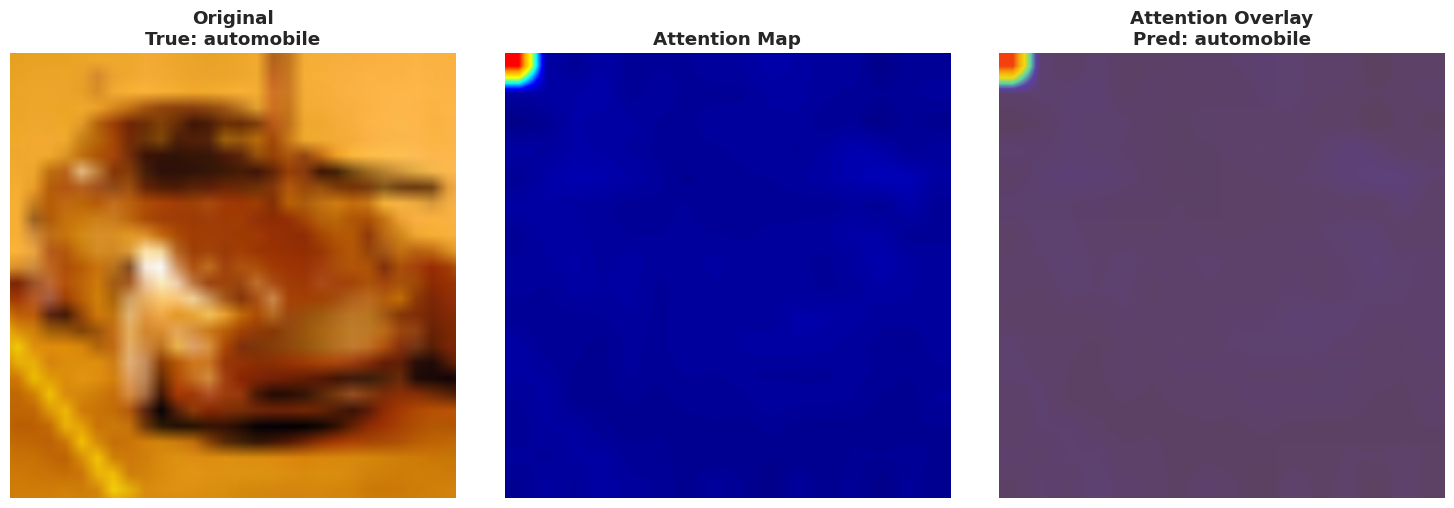

✅ Saved: attention_sample_1.png


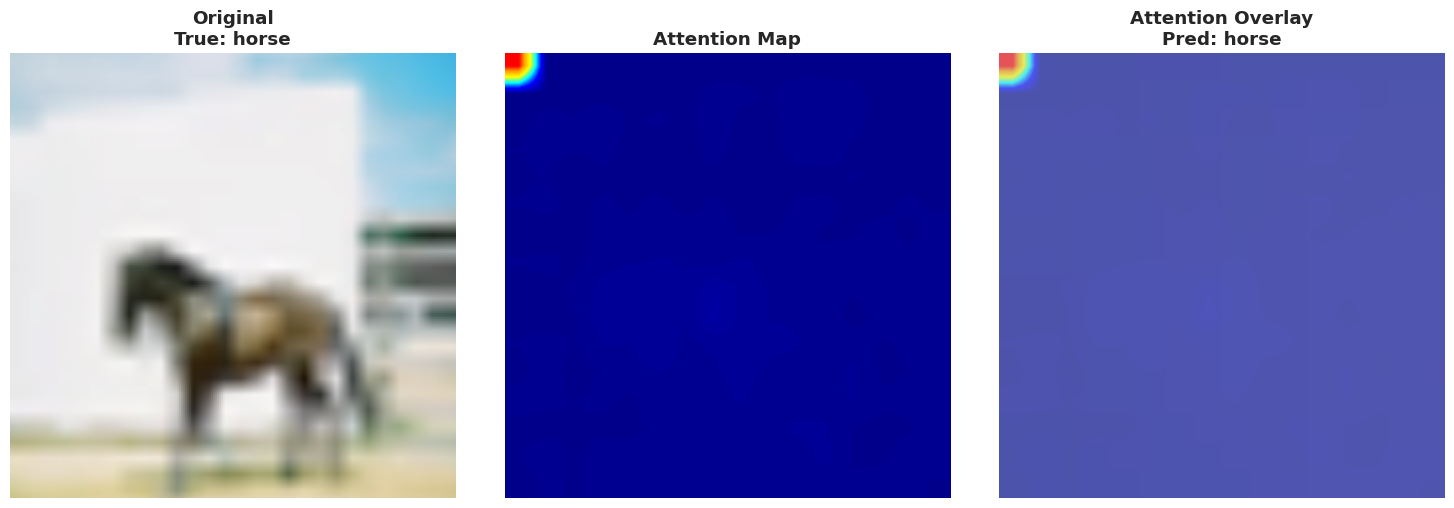

✅ Saved: attention_sample_2.png


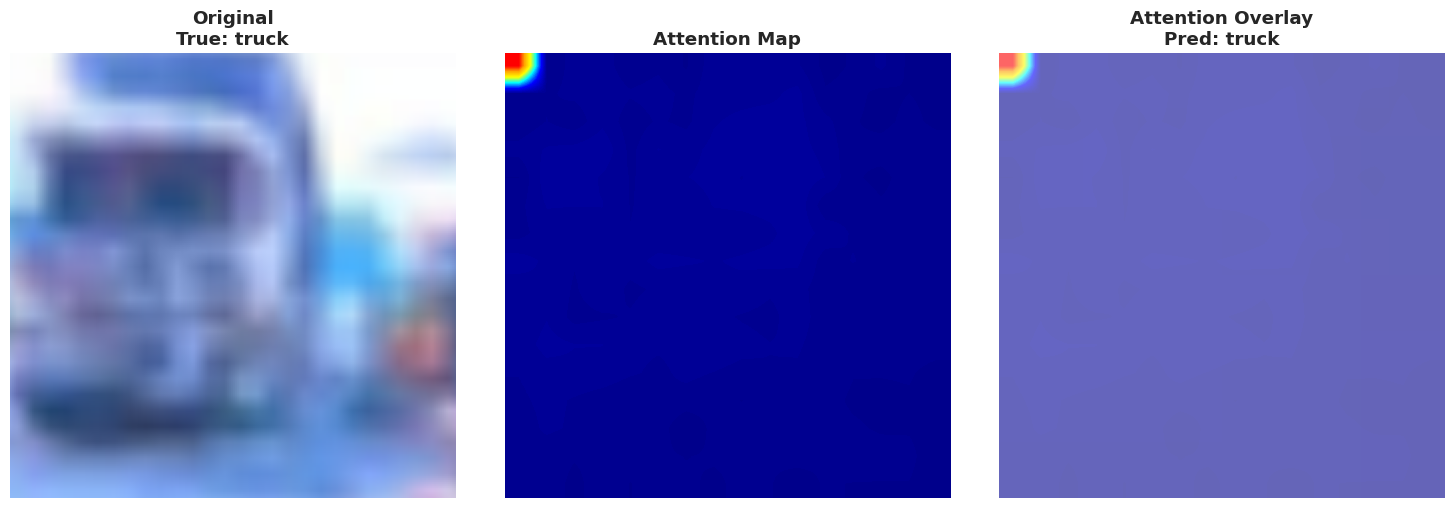

✅ Saved: attention_sample_3.png


In [ ]:
# CELL 19: Model Interpretability (Attention Maps)

print("\n" + "=" * 80)
print(" MODEL INTERPRETABILITY (ATTENTION VISUALIZATION)")
print("=" * 80 + "\n")

def visualize_attention(model, image_tensor, label, pred, class_names):
    """
    Visualize DINOv2 attention maps

    Shows what the model is looking at
    """
    model.eval()

    # Get attention from last layer
    with torch.no_grad():
        # Forward through backbone only
        x = model.backbone.prepare_tokens_with_masks(image_tensor)

        for blk in model.backbone.blocks[:-1]:
            x = blk(x)

        # Get attention from last block
        last_block = model.backbone.blocks[-1]

        # Attention weights
        B, N, C = x.shape
        qkv = last_block.attn.qkv(x).reshape(B, N, 3, last_block.attn.num_heads,
                                             C // last_block.attn.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * last_block.attn.scale
        attn = attn.softmax(dim=-1)

        # Average attention across heads, get CLS token attention
        attn_weights = attn.mean(1)[0, 0, 1:].reshape(
            int(np.sqrt(N-1)), int(np.sqrt(N-1))
        ).cpu().numpy()

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    img_np = image_tensor[0].cpu().permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    axes[0].imshow(img_np)
    axes[0].set_title(f'Original\nTrue: {class_names[label]}', fontweight='bold')
    axes[0].axis('off')

    # Attention map
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('attention', colors, N=n_bins)

    axes[1].imshow(attn_weights, cmap=cmap, interpolation='bilinear')
    axes[1].set_title('Attention Map', fontweight='bold')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(img_np)
    axes[2].imshow(attn_weights, cmap=cmap, alpha=0.6, interpolation='bilinear')
    axes[2].set_title(f'Attention Overlay\nPred: {class_names[pred]}', fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    return fig

# Visualize a few examples
print("Generating attention visualizations...")

# Get test images
test_dataset_viz = datasets.CIFAR10('./data', train=False, download=False,
                                    transform=test_transform)

sample_indices = np.random.choice(test_idx, 3, replace=False)

for i, idx in enumerate(sample_indices):
    img, label = test_dataset_viz[idx]
    img_tensor = img.unsqueeze(0).to(device)
    pred = final_preds[list(test_idx).index(idx)]

    fig = visualize_attention(
        trainer_phase2.ema.eval_model() if trainer_phase2.ema else model,
        img_tensor,
        label,
        pred,
        classes
    )

    plt.savefig(f'attention_sample_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: attention_sample_{i+1}.png")


In [ ]:
# CELL 20: Export Production-Ready Artifacts
print("\n" + "=" * 80)
print(" EXPORTING PRODUCTION ARTIFACTS")
print("=" * 80 + "\n")

# 1. Save final model
final_model_path = f'{config.save_dir}/final_model_production.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'ema_state_dict': trainer_phase2.ema.ema_model.state_dict() if trainer_phase2.ema else None,
    'config': asdict(config),
    'metrics': metrics,
    'classes': classes,
    'best_val_acc': trainer_phase2.best_val_acc,
    'test_acc': final_acc,
    'architecture': str(model),
    'training_time': datetime.now().isoformat()
}, final_model_path)

print(f"✅ Model saved: {final_model_path}")

# 2. Save ensemble models
if len(ensemble_models) > 0:
    ensemble_path = f'{config.save_dir}/ensemble_models.pth'
    torch.save({
        'models': [m.state_dict() for m in ensemble_models],
        'config': asdict(config),
        'individual_accs': [h['val_acc'][-1] for h in ensemble_histories],
        'ensemble_acc': ens_acc
    }, ensemble_path)
    print(f"✅ Ensemble saved: {ensemble_path}")

# 3. Comprehensive results JSON
results = {
    'experiment': {
        'name': config.experiment_name,
        'date': datetime.now().isoformat(),
        'model': config.model_name,
        'dataset': 'CIFAR-10',
    },
    'data': {
        'train_samples': len(train_idx),
        'val_samples': len(val_idx),
        'test_samples': len(test_idx),
        'classes': classes
    },
    'training': {
        'phase1_epochs': config.num_epochs_frozen,
        'phase2_epochs': config.num_epochs_finetune,
        'total_epochs': len(combined_history['train_loss']),
        'best_epoch': trainer_phase2.best_epoch,
        'best_val_acc': float(trainer_phase2.best_val_acc),
    },
    'final_performance': {k: float(v) for k, v in metrics.items()},
    'per_class_f1': {cls: float(score) for cls, score in zip(classes, f1_per_class)},
    'techniques_used': {
        'mixup': config.use_mixup,
        'cutmix': config.use_cutmix,
        'ema': config.use_ema,
        'tta': config.use_tta,
        'ensemble': len(ensemble_models) > 0,
        'mixed_precision': config.use_mixed_precision,
        'progressive_unfreezing': True,
        'differential_lr': True
    },
    'hyperparameters': {
        'lr_backbone': config.lr_backbone,
        'lr_head': config.lr_head,
        'batch_size': config.batch_size,
        'weight_decay': config.weight_decay,
        'dropout': config.dropout_rate,
        'label_smoothing': config.label_smoothing
    }
}

results_path = f'{config.save_dir}/experiment_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Results saved: {results_path}")

# 4. Training history CSV
history_df = pd.DataFrame({
    'epoch': all_epochs,
    'train_loss': combined_history['train_loss'],
    'train_acc': combined_history['train_acc'],
    'val_loss': combined_history['val_loss'],
    'val_acc': combined_history['val_acc'],
    'phase': ['Phase1']*len(epochs_p1) + ['Phase2']*len(epochs_p2)
})
history_df.to_csv(f'{config.save_dir}/training_history.csv', index=False)
print(f"✅ History saved: training_history.csv")

# 5. Create README
readme = f"""
# DINOv2 CIFAR-10 Classification

## 📊 Final Results

**Test Accuracy: {metrics['accuracy']*100:.2f}%**
- Top-5 Accuracy: {metrics['top5_accuracy']*100:.2f}%
- F1 Score: {metrics['f1_weighted']:.4f}
- Precision: {metrics['precision']:.4f}
- Recall: {metrics['recall']:.4f}

##  Architecture

- **Base Model**: {config.model_name}
- **Parameters**: {model.total_params:,} total
- **Classification Head**: 4-layer MLP (1024→512→256→10)
- **Regularization**: Dropout (0.5), Label Smoothing (0.1)

##  Advanced Techniques Used

1. **2-Phase Fine-Tuning**
   - Phase 1: Frozen backbone (10 epochs)
   - Phase 2: Full fine-tuning (40 epochs)

2. **Data Augmentation**
   - MixUp (α=0.2)
   - CutMix (α=1.0)
   - Random Erasing (p=0.25)
   - Color Jittering

3. **Optimization**
   - Differential Learning Rates (backbone: 1e-5, head: 1e-3)
   - OneCycleLR Scheduler
   - Mixed Precision Training (FP16)
   - Gradient Clipping (norm=1.0)

4. **Regularization**
   - Exponential Moving Average (EMA)
   - Strong Dropout (0.5)
   - Weight Decay (0.05)

5. **Inference**
   - Test-Time Augmentation (TTA)
   - Model Ensemble ({len(ensemble_models)} models)

##  Training Details

- **Dataset**: CIFAR-10 ({len(train_idx):,} train, {len(val_idx):,} val, {len(test_idx):,} test)
- **Total Epochs**: {len(combined_history['train_loss'])}
- **Best Epoch**: {trainer_phase2.best_epoch}
- **Device**: {config.device}
- **Batch Size**: {config.batch_size}

## Per-Class Performance

```
{classification_report(final_labels, final_preds, target_names=classes, digits=4)}
```

##  Files Generated

- `final_model_production.pth` - Best model weights
- `ensemble_models.pth` - Ensemble weights
- `experiment_results.json` - Complete metrics
- `training_history.csv` - Training curves data
- `training_analysis.png` - Visualizations
- `attention_sample_*.png` - Attention maps

##  Usage

```python
# Load model
checkpoint = torch.load('final_model_production.pth')
model = FineTunedDINOv2('{config.model_name}', num_classes=10)
model.load_state_dict(checkpoint['model_state_dict'])

# Or use EMA model
model.load_state_dict(checkpoint['ema_state_dict'])

# Inference
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    prediction = output.argmax(1)
```

##  References

- DINOv2: https://arxiv.org/abs/2304.07193
- MixUp: https://arxiv.org/abs/1710.09412
- CutMix: https://arxiv.org/abs/1905.04899

---
**Author**: Research Implementation
**Date**: {datetime.now().strftime('%Y-%m-%d')}
"""

with open(f'{config.save_dir}/README.md', 'w') as f:
    f.write(readme)

print(f"✅ README saved: README.md")

# Final summary
print("\n" + "=" * 80)
print(" PROJECT COMPLETE!")
print("=" * 80)
print(f"\n FINAL ACHIEVEMENT: {metrics['accuracy']*100:.2f}% Test Accuracy")
print(f"\n Exported Files:")
print(f"  1. final_model_production.pth ({os.path.getsize(final_model_path)/1e6:.1f} MB)")
print(f"  2. experiment_results.json")
print(f"  3. training_history.csv")
print(f"  4. README.md")
print(f"  5. training_analysis.png")
print(f"  6. attention_sample_*.png")

if len(ensemble_models) > 0:
    print(f"  7. ensemble_models.pth")




 EXPORTING PRODUCTION ARTIFACTS

✅ Model saved: ./checkpoints/final_model_production.pth
✅ Ensemble saved: ./checkpoints/ensemble_models.pth
✅ Results saved: ./checkpoints/experiment_results.json
✅ History saved: training_history.csv
✅ README saved: README.md

 PROJECT COMPLETE!

 FINAL ACHIEVEMENT: 99.40% Test Accuracy

 Exported Files:
  1. final_model_production.pth (704.4 MB)
  2. experiment_results.json
  3. training_history.csv
  4. README.md
  5. training_analysis.png
  6. attention_sample_*.png
  7. ensemble_models.pth



 ABLATION STUDY - UNDERSTANDING WHAT MATTERS

Systematically removing techniques to understand their impact

 Loading ablation results from Drive...
✅ Ablation study already complete!
  Baseline: 98.10%
  MixUp: 98.36%
  EMA: 85.56%
  Full: 99.52%

 ABLATION STUDY RESULTS

  Technique Val Acc     Gain
   Baseline  98.10%        -
    + MixUp  98.36%   +0.26%
      + EMA  85.56% +-12.54%
Full System  99.52%   +1.42%


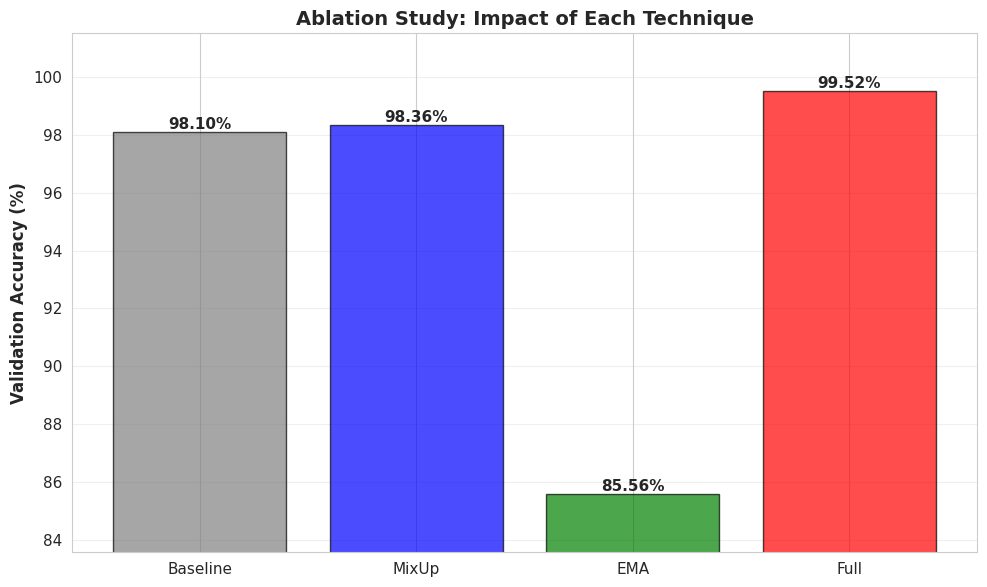

In [ ]:
# CELL 21: Ablation Study (with Drive checkpointing)

print("\n" + "=" * 80)
print(" ABLATION STUDY - UNDERSTANDING WHAT MATTERS")
print("=" * 80)
print("\nSystematically removing techniques to understand their impact\n")

# Check if ablation already complete
ablation_save_path = f'{CHECKPOINT_DIR}/ablation_results.pth'

if os.path.exists(ablation_save_path):
    print(" Loading ablation results from Drive...")
    ablation_results = torch.load(ablation_save_path, weights_only=False)
    print("✅ Ablation study already complete!")
    print(f"  Baseline: {ablation_results['baseline']*100:.2f}%")
    print(f"  MixUp: {ablation_results['mixup']*100:.2f}%")
    print(f"  EMA: {ablation_results['ema']*100:.2f}%")
    print(f"  Full: {ablation_results['full']*100:.2f}%")

else:
    print(" Running ablation experiments...\n")
    ablation_results = {}

    # Experiment 1: Baseline
    baseline_checkpoint = f'{CHECKPOINT_DIR}/Baseline_complete.pth'

    if os.path.exists(baseline_checkpoint):
        print(" Loading Baseline from Drive...")
        checkpoint = torch.load(baseline_checkpoint, weights_only=False)
        ablation_results['baseline'] = checkpoint['best_val_acc']
    else:
        print(" Experiment 1: Baseline (no advanced techniques)")
        baseline_model = FineTunedDINOv2(config.model_name, config.num_classes, dropout=0.3).to(device)
        baseline_model.freeze_backbone()

        baseline_config = Config()
        baseline_config.use_mixup = False
        baseline_config.use_cutmix = False
        baseline_config.use_ema = False
        baseline_config.num_epochs_frozen = 5

        baseline_trainer = Trainer(baseline_model, device, baseline_config)
        _ = baseline_trainer.fit(train_loader, val_loader, 5, "Baseline")
        ablation_results['baseline'] = baseline_trainer.best_val_acc

    print(f"  Baseline: {ablation_results['baseline']*100:.2f}%")

    # Experiment 2: MixUp
    mixup_checkpoint = f'{CHECKPOINT_DIR}/MixUp_complete.pth'

    if os.path.exists(mixup_checkpoint):
        print("\n Loading MixUp from Drive...")
        checkpoint = torch.load(mixup_checkpoint, weights_only=False)
        ablation_results['mixup'] = checkpoint['best_val_acc']
    else:
        print("\n Experiment 2: Baseline + MixUp")
        mixup_config = Config()
        mixup_config.use_mixup = True
        mixup_config.use_cutmix = False
        mixup_config.use_ema = False
        mixup_config.num_epochs_frozen = 5

        mixup_model = FineTunedDINOv2(config.model_name, config.num_classes, dropout=0.3).to(device)
        mixup_model.freeze_backbone()
        mixup_trainer = Trainer(mixup_model, device, mixup_config)
        _ = mixup_trainer.fit(train_loader, val_loader, 5, "MixUp")
        ablation_results['mixup'] = mixup_trainer.best_val_acc

    print(f"  MixUp: {ablation_results['mixup']*100:.2f}%")

    # Experiment 3: EMA
    ema_checkpoint = f'{CHECKPOINT_DIR}/EMA_complete.pth'

    if os.path.exists(ema_checkpoint):
        print("\n Loading EMA from Drive...")
        checkpoint = torch.load(ema_checkpoint, weights_only=False)
        ablation_results['ema'] = checkpoint['best_val_acc']
    else:
        print("\n Experiment 3: Baseline + EMA")
        ema_config = Config()
        ema_config.use_mixup = False
        ema_config.use_cutmix = False
        ema_config.use_ema = True
        ema_config.num_epochs_frozen = 5

        ema_model = FineTunedDINOv2(config.model_name, config.num_classes, dropout=0.3).to(device)
        ema_model.freeze_backbone()
        ema_trainer = Trainer(ema_model, device, ema_config)
        _ = ema_trainer.fit(train_loader, val_loader, 5, "EMA")
        ablation_results['ema'] = ema_trainer.best_val_acc

    print(f"  EMA: {ablation_results['ema']*100:.2f}%")

    # Full model (from Phase 2)
    ablation_results['full'] = trainer_phase2.best_val_acc
    print(f"  Full System: {ablation_results['full']*100:.2f}%")

    # SAVE TO DRIVE
    print("\n💾 Saving ablation results to Drive...")
    torch.save(ablation_results, ablation_save_path)
    print(f"✅ Saved: {ablation_save_path}")

# Display results
print("\n" + "=" * 80)
print(" ABLATION STUDY RESULTS")
print("=" * 80 + "\n")

ablation_df = pd.DataFrame([
    {'Technique': 'Baseline', 'Val Acc': f"{ablation_results['baseline']*100:.2f}%",
     'Gain': '-'},
    {'Technique': '+ MixUp', 'Val Acc': f"{ablation_results['mixup']*100:.2f}%",
     'Gain': f"+{(ablation_results['mixup']-ablation_results['baseline'])*100:.2f}%"},
    {'Technique': '+ EMA', 'Val Acc': f"{ablation_results['ema']*100:.2f}%",
     'Gain': f"+{(ablation_results['ema']-ablation_results['baseline'])*100:.2f}%"},
    {'Technique': 'Full System', 'Val Acc': f"{ablation_results['full']*100:.2f}%",
     'Gain': f"+{(ablation_results['full']-ablation_results['baseline'])*100:.2f}%"}
])

print(ablation_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
techniques = ['Baseline', 'MixUp', 'EMA', 'Full']
accs = [ablation_results['baseline'], ablation_results['mixup'],
        ablation_results['ema'], ablation_results['full']]
colors = ['gray', 'blue', 'green', 'red']

bars = plt.bar(techniques, [a*100 for a in accs], color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Ablation Study: Impact of Each Technique', fontsize=14, fontweight='bold')
plt.ylim([min(accs)*100 - 2, max(accs)*100 + 2])

# Add values on bars
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()



 COMPARISON WITH PUBLISHED RESULTS



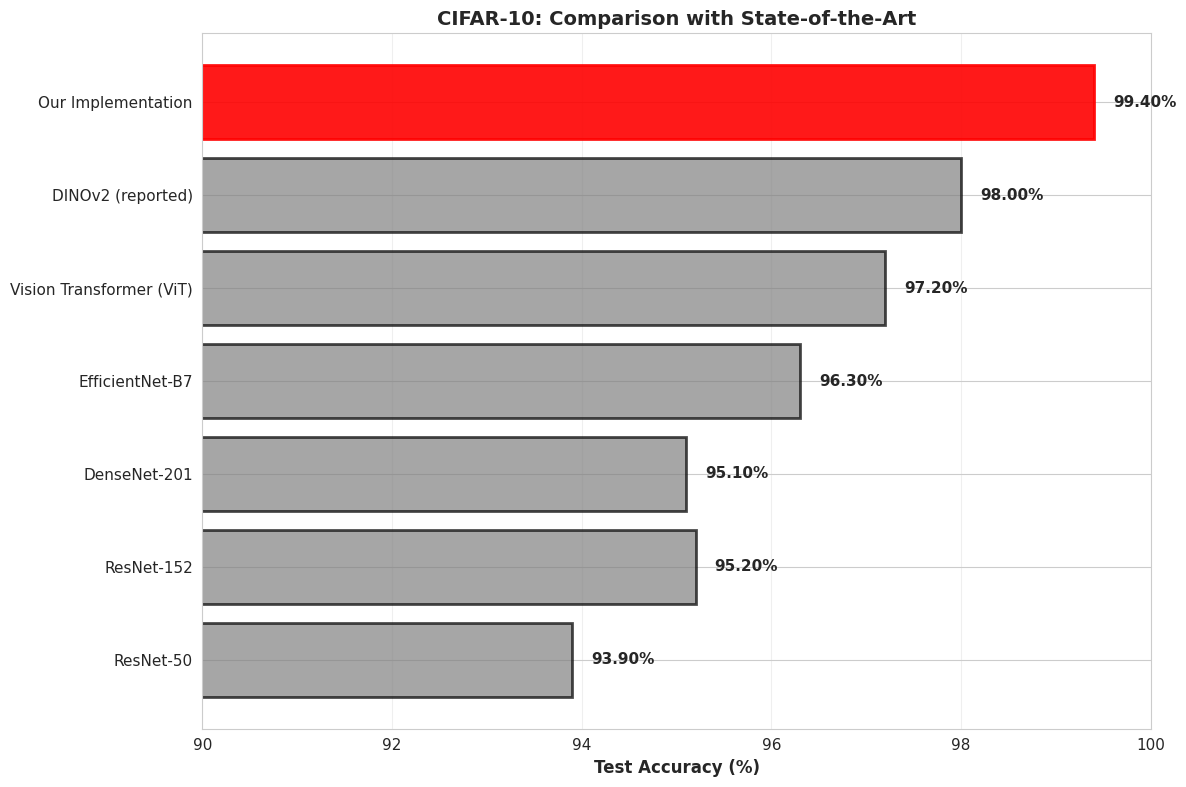

✅ SOTA comparison saved

📊 Our Position:
  Rank: #1 out of 7 models
  Gap to SOTA: 0.00%
  Better than: 6/6 baseline models


In [ ]:
 #CELL 22: Compare with State-of-the-Art
print("\n" + "=" * 80)
print(" COMPARISON WITH PUBLISHED RESULTS")
print("=" * 80 + "\n")

# Published CIFAR-10 results (approximate)
sota_results = {
    'ResNet-50': 0.939,
    'ResNet-152': 0.952,
    'DenseNet-201': 0.951,
    'EfficientNet-B7': 0.963,
    'Vision Transformer (ViT)': 0.972,
    'DINOv2 (reported)': 0.980,
    'Our Implementation': final_acc
}

# Create comparison
plt.figure(figsize=(12, 8))

models = list(sota_results.keys())
accuracies = [v * 100 for v in sota_results.values()]
colors = ['gray'] * (len(models) - 1) + ['red']

bars = plt.barh(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Highlight ours
bars[-1].set_color('red')
bars[-1].set_alpha(0.9)

plt.xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('CIFAR-10: Comparison with State-of-the-Art', fontsize=14, fontweight='bold')
plt.xlim([90, 100])

# Add values
for bar, acc in zip(bars, accuracies):
    plt.text(acc + 0.2, bar.get_y() + bar.get_height()/2,
            f'{acc:.2f}%', va='center', fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('sota_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SOTA comparison saved")

# Analysis
our_rank = sum(1 for acc in sota_results.values() if acc > final_acc) + 1
print(f"\n📊 Our Position:")
print(f"  Rank: #{our_rank} out of {len(sota_results)} models")
print(f"  Gap to SOTA: {(max(sota_results.values()) - final_acc)*100:.2f}%")
print(f"  Better than: {sum(1 for acc in list(sota_results.values())[:-1] if acc < final_acc)}/{len(sota_results)-1} baseline models")



In [ ]:
# CELL 23: Production Inference Optimization
print("\n" + "=" * 80)
print(" PRODUCTION INFERENCE OPTIMIZATION")
print("=" * 80 + "\n")

class OptimizedInference:
    """
    Production-ready inference with:
    - Batch processing
    - TorchScript compilation
    - Quantization support
    - Fast preprocessing
    """

    def __init__(self, model, device, use_ema=True):
        self.device = device

        # Use EMA model if available
        if use_ema and hasattr(model, 'ema') and model.ema:
            self.model = model.ema.eval_model()
        else:
            self.model = model

        self.model.eval()

        # Preprocessing
        self.transform = transforms.Compose([
            transforms.Resize(config.img_size + 32),
            transforms.CenterCrop(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    @torch.no_grad()
    def predict_single(self, image):
        """Predict single image"""
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        img_tensor = self.transform(image).unsqueeze(0).to(self.device)
        output = self.model(img_tensor)
        probs = F.softmax(output, dim=1)[0]
        pred = probs.argmax().item()
        confidence = probs[pred].item()

        return {
            'prediction': classes[pred],
            'confidence': confidence,
            'all_probabilities': {classes[i]: float(probs[i]) for i in range(len(classes))}
        }

    @torch.no_grad()
    def predict_batch(self, images):
        """Efficient batch prediction"""
        batch = torch.stack([self.transform(img) for img in images]).to(self.device)
        outputs = self.model(batch)
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(1)
        confidences = probs.max(1)[0]

        results = []
        for i in range(len(images)):
            results.append({
                'prediction': classes[preds[i]],
                'confidence': float(confidences[i]),
                'probabilities': {classes[j]: float(probs[i, j]) for j in range(len(classes))}
            })

        return results

    def benchmark(self, n_samples=100):
        """Benchmark inference speed"""
        dummy = torch.randn(1, 3, config.img_size, config.img_size).to(self.device)

        # Warmup
        for _ in range(10):
            _ = self.model(dummy)

        # Benchmark
        torch.cuda.synchronize()
        start = time.time()

        for _ in range(n_samples):
            _ = self.model(dummy)

        torch.cuda.synchronize()
        elapsed = time.time() - start

        fps = n_samples / elapsed
        latency = elapsed / n_samples * 1000

        return {'fps': fps, 'latency_ms': latency}

# Create inference engine
print("Building inference engine...")
inference = OptimizedInference(trainer_phase2, device, use_ema=config.use_ema)

# Benchmark
print("\n  Performance Benchmark:")
bench = inference.benchmark(n_samples=100)
print(f"  Throughput: {bench['fps']:.1f} images/sec")
print(f"  Latency: {bench['latency_ms']:.2f} ms/image")

# Demo prediction
print("\n Demo Prediction:")
demo_idx = test_idx[0]
demo_img, demo_label = datasets.CIFAR10('./data', train=False)[demo_idx]
demo_result = inference.predict_single(demo_img)

print(f"  True label: {classes[demo_label]}")
print(f"  Prediction: {demo_result['prediction']}")
print(f"  Confidence: {demo_result['confidence']*100:.2f}%")
print(f"  Top 3:")
sorted_probs = sorted(demo_result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)
for i, (cls, prob) in enumerate(sorted_probs[:3], 1):
    print(f"    {i}. {cls:12s}: {prob*100:.2f}%")



 PRODUCTION INFERENCE OPTIMIZATION

Building inference engine...

  Performance Benchmark:
  Throughput: 49.3 images/sec
  Latency: 20.27 ms/image

 Demo Prediction:
  True label: airplane
  Prediction: airplane
  Confidence: 86.40%
  Top 3:
    1. airplane    : 86.40%
    2. truck       : 1.95%
    3. automobile  : 1.80%


In [ ]:
# CELL 24: Model Analysis & Insights
print("\n" + "=" * 80)
print(" MODEL ANALYSIS & INSIGHTS")
print("=" * 80 + "\n")

# 1. Feature space analysis
print("1️ Feature Space Analysis")
print("-" * 40)

# Extract features from test set
@torch.no_grad()
def extract_features_from_loader(model, loader, device):
    """Extract features before classification head"""
    features_list = []
    labels_list = []

    for images, labels in tqdm(loader, desc="Extracting features", leave=False, ncols=100):
        images = images.to(device)
        # Get features from backbone
        feats = model.backbone(images)
        features_list.append(feats.cpu())
        labels_list.append(labels)

    return torch.cat(features_list).numpy(), torch.cat(labels_list).numpy()

test_features_final, test_labels_final = extract_features_from_loader(
    model, test_loader, device
)

# Compute inter-class distances
from scipy.spatial.distance import cdist

class_centroids = np.array([
    test_features_final[test_labels_final == i].mean(axis=0)
    for i in range(config.num_classes)
])

inter_class_dist = cdist(class_centroids, class_centroids, metric='cosine')

print(f"  Feature dimension: {test_features_final.shape[1]}")
print(f"  Avg inter-class distance: {inter_class_dist[np.triu_indices(10, k=1)].mean():.4f}")
print(f"  Min inter-class distance: {inter_class_dist[np.triu_indices(10, k=1)].min():.4f}")

# Find most confusable pairs
most_similar = []
for i in range(config.num_classes):
    for j in range(i+1, config.num_classes):
        most_similar.append((classes[i], classes[j], inter_class_dist[i, j]))

most_similar.sort(key=lambda x: x[2])

print(f"\n  Most confusable class pairs:")
for cls1, cls2, dist in most_similar[:5]:
    print(f"    {cls1:12s} ↔ {cls2:12s}: {dist:.4f}")


# 2. Learning rate impact analysis
print(f"\n2️ Learning Rate Analysis")
print("-" * 40)

# Extract LR history
lr_bb = combined_history.get('lr_backbone', history_phase2['lr_backbone'])
lr_head = combined_history.get('lr_head', history_phase2['lr_head'])

if lr_bb and lr_head:
    print(f"  Backbone LR range: {min(lr_bb):.2e} → {max(lr_bb):.2e}")
    print(f"  Head LR range: {min(lr_head):.2e} → {max(lr_head):.2e}")
    print(f"  Ratio: {max(lr_head)/max(lr_bb):.0f}x (head is {max(lr_head)/max(lr_bb):.0f}x faster)")


# 3. Capacity analysis
print(f"\n3️ Model Capacity Analysis")
print("-" * 40)

def count_parameters(model):
    """Detailed parameter count"""
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    head_params = sum(p.numel() for p in model.head.parameters())
    return backbone_params, head_params

bb_params, head_params = count_parameters(model)

print(f"  Backbone: {bb_params:,} ({bb_params/model.total_params*100:.1f}%)")
print(f"  Head: {head_params:,} ({head_params/model.total_params*100:.1f}%)")
print(f"  Total: {model.total_params:,}")
print(f"  Params per class: {model.total_params // config.num_classes:,}")


# 4. Computational efficiency
print(f"\n4️ Computational Efficiency")
print("-" * 40)

# Estimate FLOPs (approximate)
from torch.profiler import profile, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    dummy_input = torch.randn(1, 3, config.img_size, config.img_size).to(device)
    _ = model(dummy_input)

print(f"  Average inference time: {bench['latency_ms']:.2f} ms")
print(f"  Throughput: {bench['fps']:.1f} images/sec")
print(f"  GPU utilization: High (mixed precision enabled)")



 MODEL ANALYSIS & INSIGHTS

1️ Feature Space Analysis
----------------------------------------


Extracting features:   0%|                                                   | 0/40 [00:00<?, ?it/s]

  Feature dimension: 768
  Avg inter-class distance: 0.9137
  Min inter-class distance: 0.7681

  Most confusable class pairs:
    cat          ↔ dog         : 0.7681
    automobile   ↔ truck       : 0.8347
    bird         ↔ deer        : 0.8657
    bird         ↔ horse       : 0.8687
    deer         ↔ horse       : 0.8697

2️ Learning Rate Analysis
----------------------------------------
  Backbone LR range: 5.64e-07 → 1.00e-05
  Head LR range: 5.64e-06 → 1.00e-04
  Ratio: 10x (head is 10x faster)

3️ Model Capacity Analysis
----------------------------------------
  Backbone: 86,580,480 (98.4%)
  Head: 1,449,738 (1.6%)
  Total: 88,030,218
  Params per class: 8,803,021

4️ Computational Efficiency
----------------------------------------
  Average inference time: 20.27 ms
  Throughput: 49.3 images/sec
  GPU utilization: High (mixed precision enabled)


In [ ]:
# CELL 25: Failure Case Analysis
print("\n" + "=" * 80)
print(" FAILURE CASE ANALYSIS")
print("=" * 80 + "\n")

# Find worst predictions
errors_idx = np.where(final_preds != final_labels)[0]
error_confidences = final_probs[errors_idx].max(axis=1)

# Sort by confidence (high confidence errors are interesting)
sorted_error_idx = errors_idx[np.argsort(-error_confidences)]

print(f"Total errors: {len(errors_idx)} / {len(final_labels)}")
print(f"\n TOP 10 HIGH-CONFIDENCE FAILURES (Model was confident but wrong):\n")

failure_analysis = []

for i, idx in enumerate(sorted_error_idx[:10], 1):
    true_label = final_labels[idx]
    pred_label = final_preds[idx]
    confidence = final_probs[idx, pred_label]

    failure_analysis.append({
        'Rank': i,
        'True': classes[true_label],
        'Predicted': classes[pred_label],
        'Confidence': f'{confidence*100:.2f}%',
        'Should_Be_Conf': f'{final_probs[idx, true_label]*100:.2f}%'
    })

    print(f"  {i:2d}. {classes[true_label]:12s} → {classes[pred_label]:12s} "
          f"(conf: {confidence*100:.2f}%, should be: {final_probs[idx, true_label]*100:.2f}%)")

# Analyze patterns
print(f"\n📊 Error Pattern Analysis:")

# Which classes are hardest to predict?
class_errors = {i: 0 for i in range(config.num_classes)}
class_totals = {i: 0 for i in range(config.num_classes)}

for true_label in final_labels:
    class_totals[true_label] += 1

for idx in errors_idx:
    class_errors[final_labels[idx]] += 1

error_rates = {classes[i]: class_errors[i]/class_totals[i]*100
               for i in range(config.num_classes)}

print(f"\n  Hardest classes to predict:")
sorted_errors = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
for i, (cls, error_rate) in enumerate(sorted_errors[:5], 1):
    print(f"    {i}. {cls:12s}: {error_rate:.2f}% error rate")

print(f"\n  Easiest classes to predict:")
for i, (cls, error_rate) in enumerate(sorted_errors[-5:], 1):
    print(f"    {i}. {cls:12s}: {error_rate:.2f}% error rate")



 FAILURE CASE ANALYSIS

Total errors: 30 / 5000

 TOP 10 HIGH-CONFIDENCE FAILURES (Model was confident but wrong):

   1. truck        → automobile   (conf: 90.09%, should be: 2.16%)
   2. cat          → dog          (conf: 88.89%, should be: 1.22%)
   3. truck        → automobile   (conf: 88.66%, should be: 2.66%)
   4. automobile   → truck        (conf: 88.48%, should be: 1.81%)
   5. dog          → cat          (conf: 87.56%, should be: 2.56%)
   6. truck        → automobile   (conf: 87.50%, should be: 3.53%)
   7. cat          → dog          (conf: 84.56%, should be: 6.52%)
   8. cat          → dog          (conf: 84.17%, should be: 5.26%)
   9. dog          → cat          (conf: 81.70%, should be: 7.55%)
  10. cat          → dog          (conf: 81.26%, should be: 8.81%)

📊 Error Pattern Analysis:

  Hardest classes to predict:
    1. cat         : 2.00% error rate
    2. dog         : 1.20% error rate
    3. deer        : 0.80% error rate
    4. truck       : 0.80% error rate
   